## Project: Rental Apartment Analysis Tel Aviv - Jaffa- Machine Learning – Part 2
### Presented by:  
### Amichay Nager -316225986 
### Tair Mimon-322240615

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score, KFold,LeaveOneOut, LeavePOut, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error ,mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import requests
import time
import getpass
import googlemaps
import movecolumn as mc

#### installations

In [2]:
#!pip install lightgbm
#!pip install missingno
#!pip install movecolumn
#!pip install googlemaps

### The original dataset


In [3]:
# Read the file
file_name = r'https://raw.githubusercontent.com/amichay1234/project_part2-/refs/heads/main/train.csv'
dataset = pd.read_csv(file_name)

# New column order
new_order = [
    "property_type", "neighborhood", "address", "room_num", "floor", "area", "garden_area", "days_to_enter", "num_of_payments",
    "monthly_arnona", "building_tax", "total_floors", "description", "has_parking", "has_storage", "elevator", "ac", "handicap", "has_bars",
    "has_safe_room", "has_balcony", "is_furnished", "is_renovated", "num_of_images", "distance_from_center", "price"]

# Change the order of the columns accordingly.
dataset = dataset[new_order]

# Displaying the first 5 lines
dataset.head(5)


,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,num_of_images,distance_from_center,price
0,דירה,הצפון הישן החלק המרכזי,"מהר""ל 25",3.0,2,71,NaN,0.0,12.0,467.0,...,1,0,0,1,1,0,0,6.0,1005.0,10150.0
1,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 35,3.0,1,70,NaN,0.0,12.0,240.0,...,1,0,1,0,1,0,0,3.0,253.0,6600.0
2,דירה,הצפון הישן החלק המרכזי,וורמיזה 5,2.5,1,65,NaN,NaN,12.0,400.0,...,1,1,0,0,1,0,1,8.0,740.0,9000.0
3,דירה,הצפון הישן החלק המרכזי,עמנואל הרומי 30,2.0,3,40,NaN,0.0,12.0,100.0,...,0,0,0,0,0,0,0,2.0,1206.0,5800.0
4,דירה,הצפון הישן החלק המרכזי,ארלוזורוב 50,3.0,1,70,NaN,0.0,11.0,250.0,...,1,0,1,0,0,0,1,5.0,255.0,7700.0


#### I created a copy of the original data in order to test it on the prepare_data

In [4]:
my_data_test=dataset.copy()

The shape of the data

In [5]:
num_rows = dataset.shape[1]
print(f"Number of rows: {num_rows}")

num_columns = dataset.shape[0]
print(f"Number of columns: {num_columns}")

Number of rows: 26
Number of columns: 788


### Let's look at the distribution of the columns.


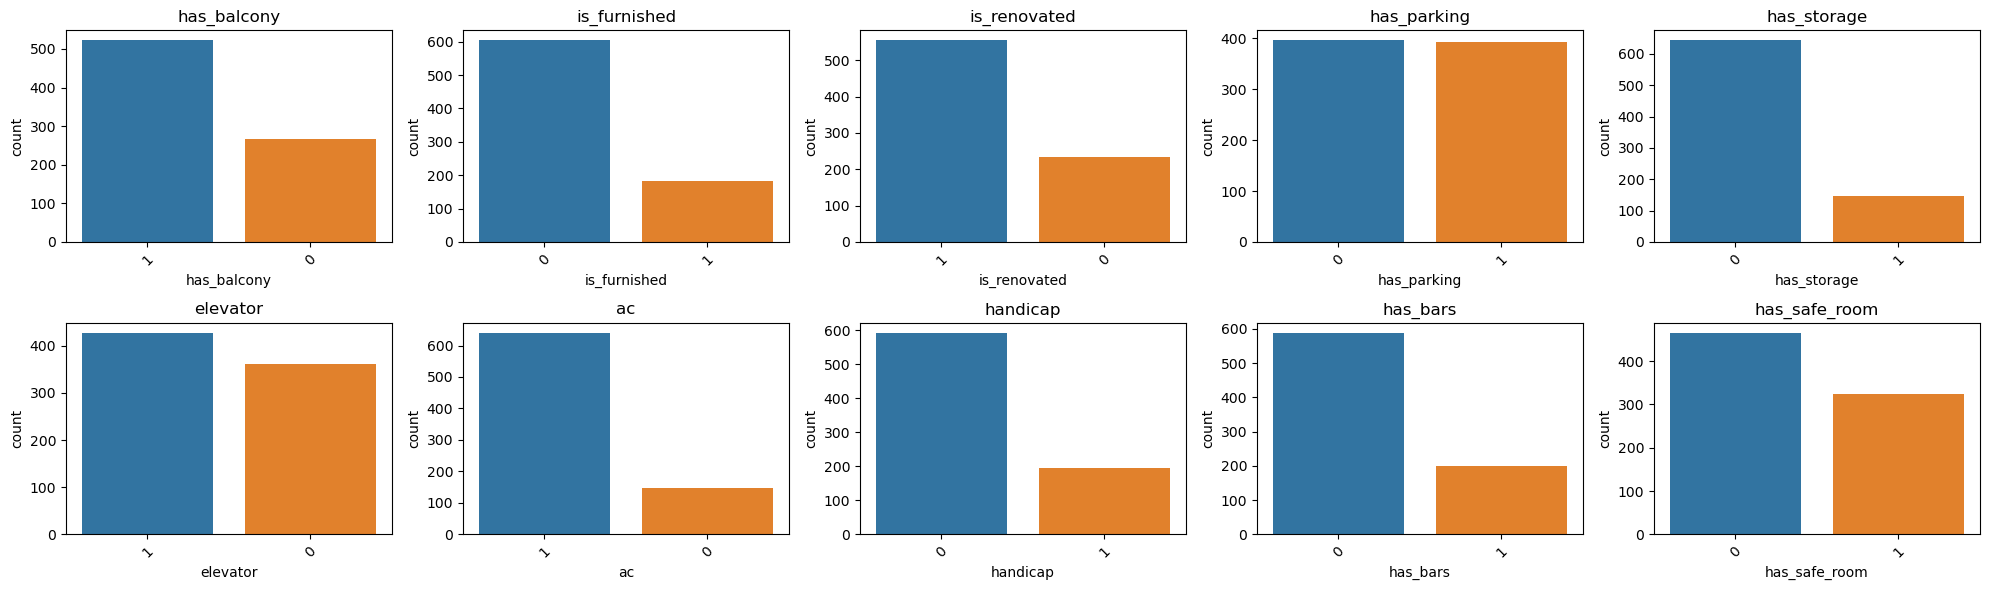

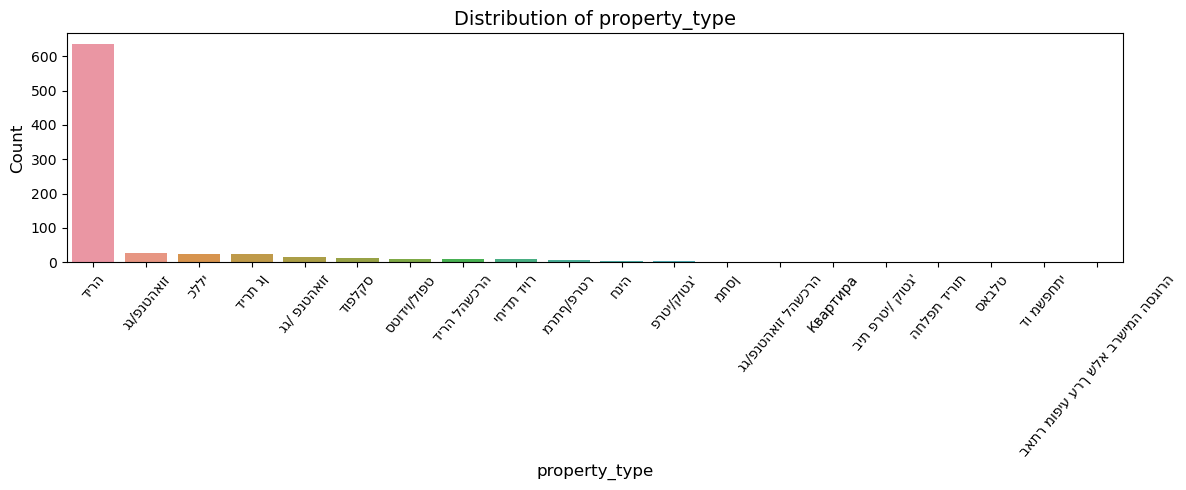

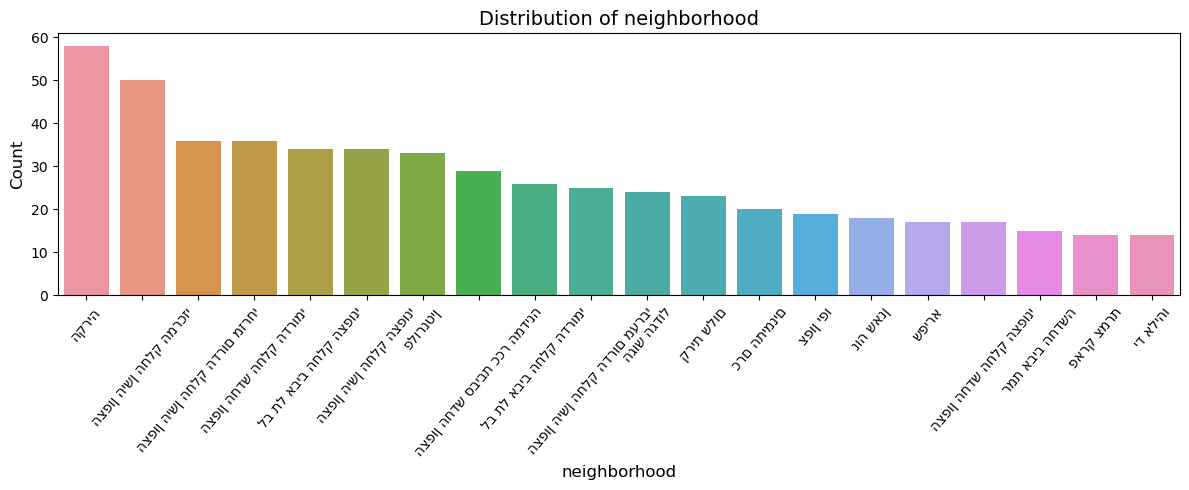

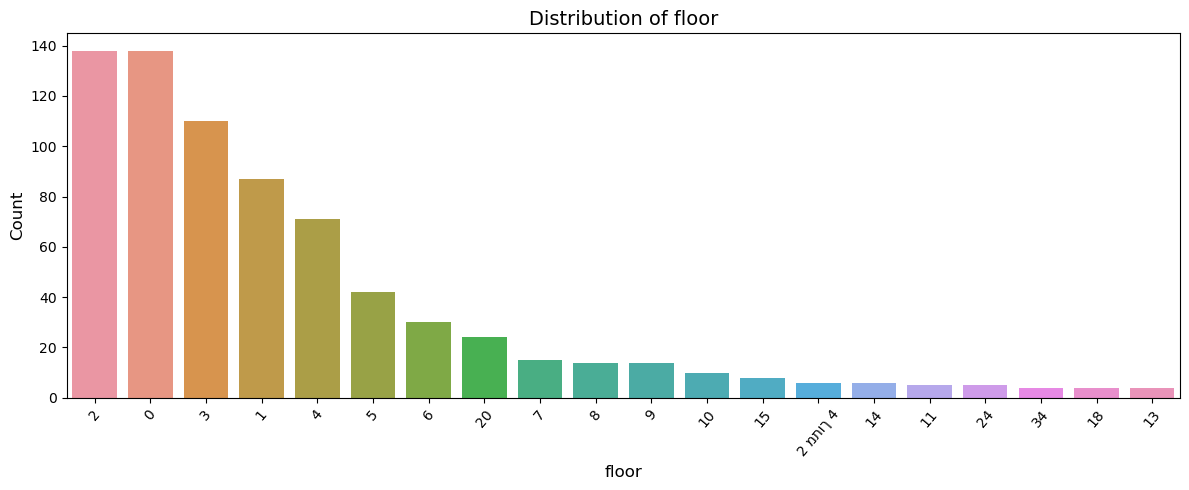

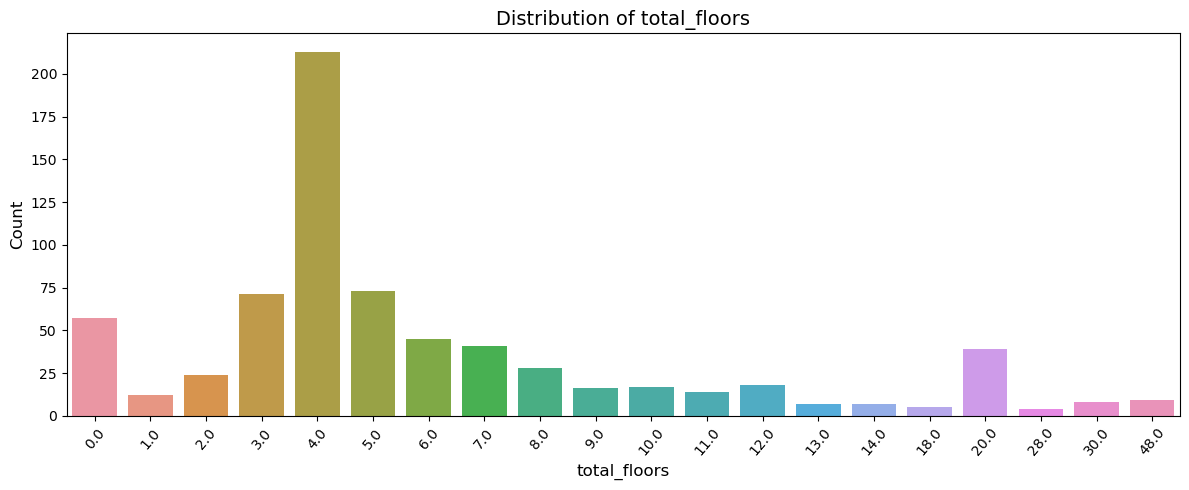

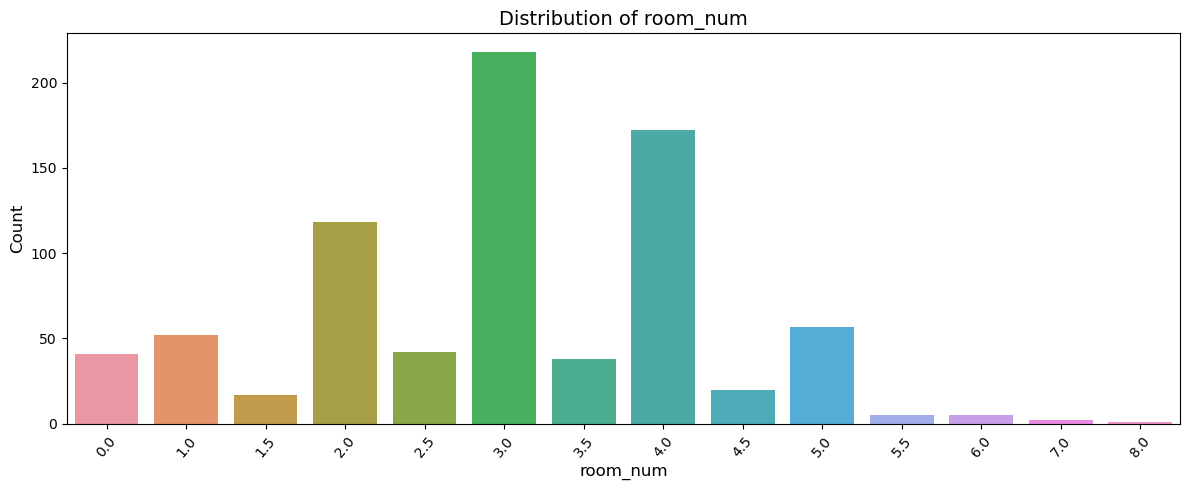

In [6]:
# Categorical and binary columns to visualize
categorical_cols = ['has_balcony', 'is_furnished', 'is_renovated']
binary_cols = ['has_parking', 'has_storage', 'elevator', 'ac', 'handicap',
               'has_bars', 'has_safe_room']
all_cat_cols = categorical_cols + binary_cols

# Define the layout for subplots
n = len(all_cat_cols)
cols = 5  # number of columns in the subplot grid
rows = (n + cols - 1) // cols  # calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3))
axes = axes.flatten()

# Plot countplots for each binary/categorical column
for i, col in enumerate(all_cat_cols):
    sns.countplot(data=dataset, x=col, ax=axes[i], order=dataset[col].value_counts().index)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots (if any remain)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Categorical columns with many unique values (e.g. street names, room counts)
long_cat_cols = ['property_type', 'neighborhood', 'floor', 'total_floors', 'room_num']

# Plot barplots for the top 20 most frequent values in each column
for col in long_cat_cols:
    plt.figure(figsize=(12, 5))  # increase figure size for readability
    top_values = dataset[col].value_counts().nlargest(20)  # show only top 20 categories
    sns.barplot(x=top_values.index, y=top_values.values)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xticks(rotation=50, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()
    plt.show()


Displaying the distributions of the columns

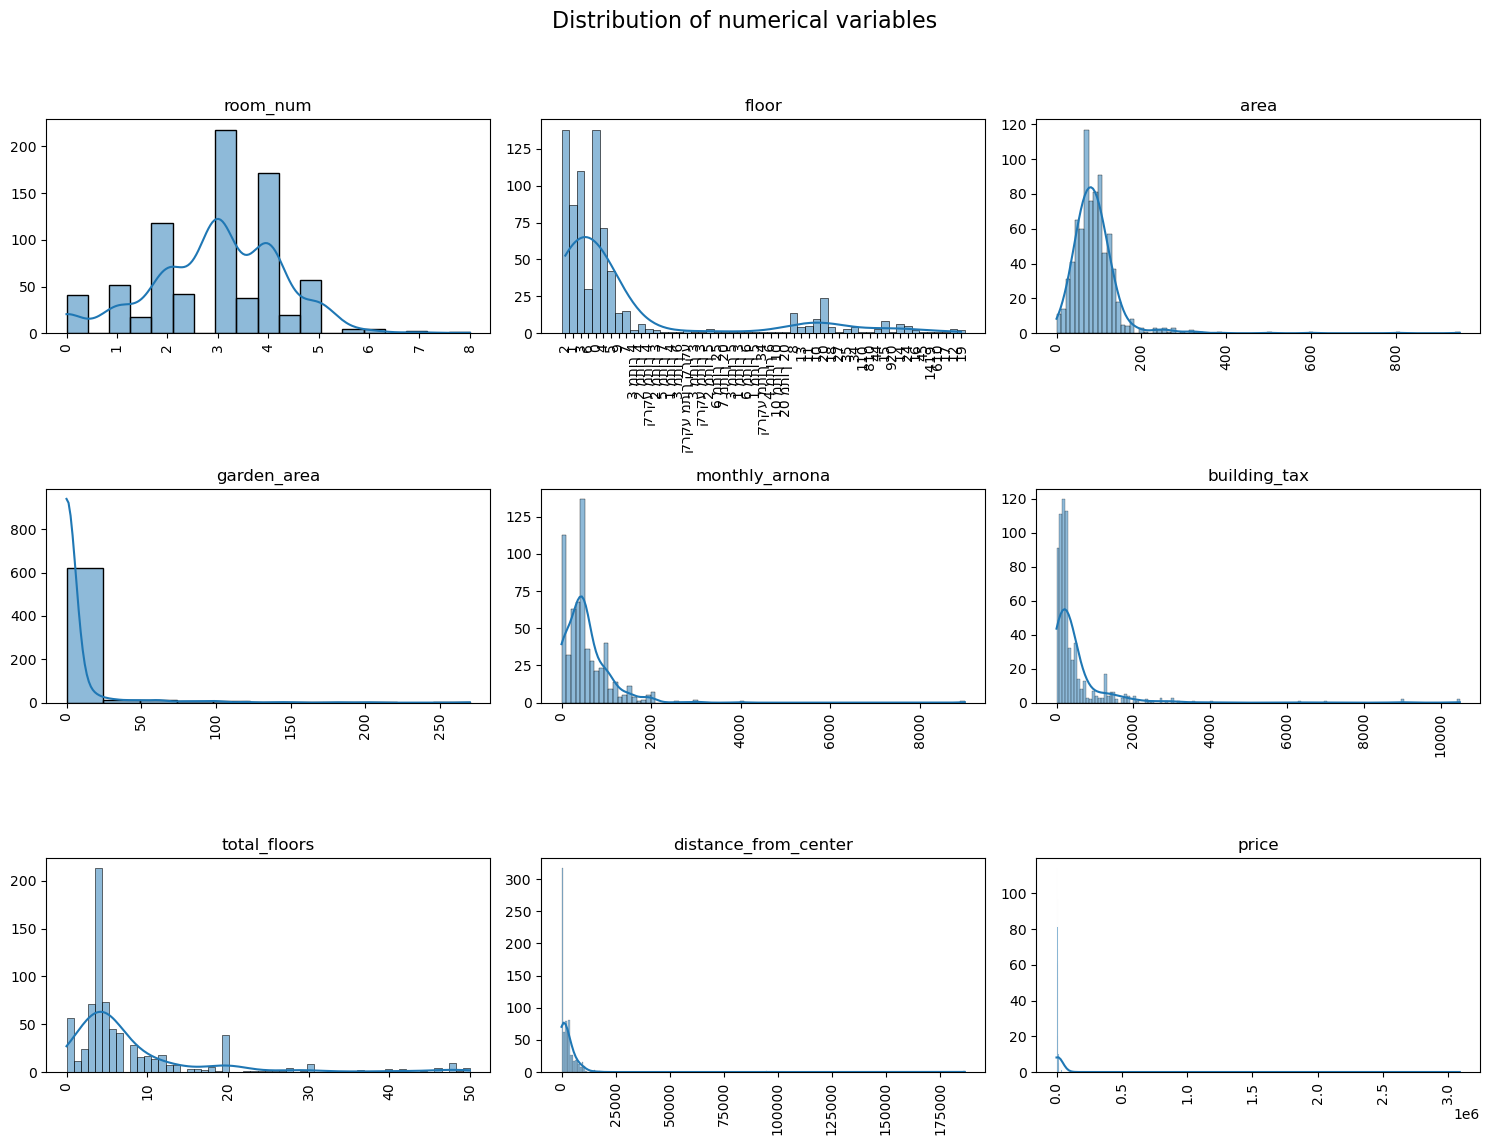

In [7]:
# List of numerical columns to visualize
columns_to_plot = [
    "room_num", "floor", "area", "garden_area", "monthly_arnona",
    "building_tax", "total_floors", "distance_from_center", "price"
]

# Set up a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle('Distribution of numerical variables', fontsize=16)

# Iterate through each column and plot its distribution
for i, col in enumerate(columns_to_plot):
    row = i // 3           
    col_idx = i % 3        
    sns.histplot(dataset[col], kde=True, ax=axes[row][col_idx])  
    axes[row][col_idx].set_title(col)             
    axes[row][col_idx].set_xlabel("")             
    axes[row][col_idx].set_ylabel("")            
    axes[row][col_idx].tick_params(axis='x', labelrotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and make space for the main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Let's look at the correlations.


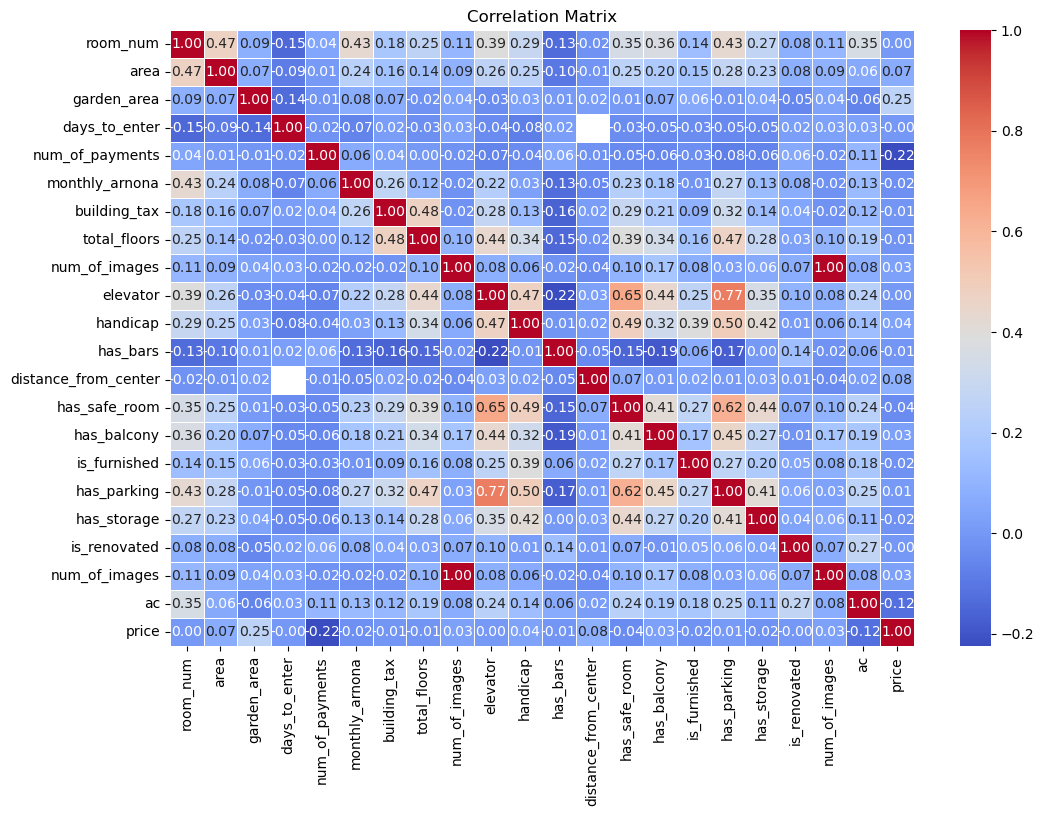

In [8]:


# List of numerical columns
numeric_cols = ['room_num', 'area', 'garden_area', 'days_to_enter', 'num_of_payments',
                'monthly_arnona', 'building_tax', 'total_floors', 'num_of_images', "elevator", "handicap", "has_bars",
                'distance_from_center',"has_safe_room","has_balcony", "is_furnished","has_parking", "has_storage", "is_renovated", "num_of_images" ,'ac', 'price']

# Calculation of the correlation matrix
corr_matrix = dataset[numeric_cols].corr()

# Matrix drawing
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


#### Graphs of the relationship between numerical variables and the price of the apartment

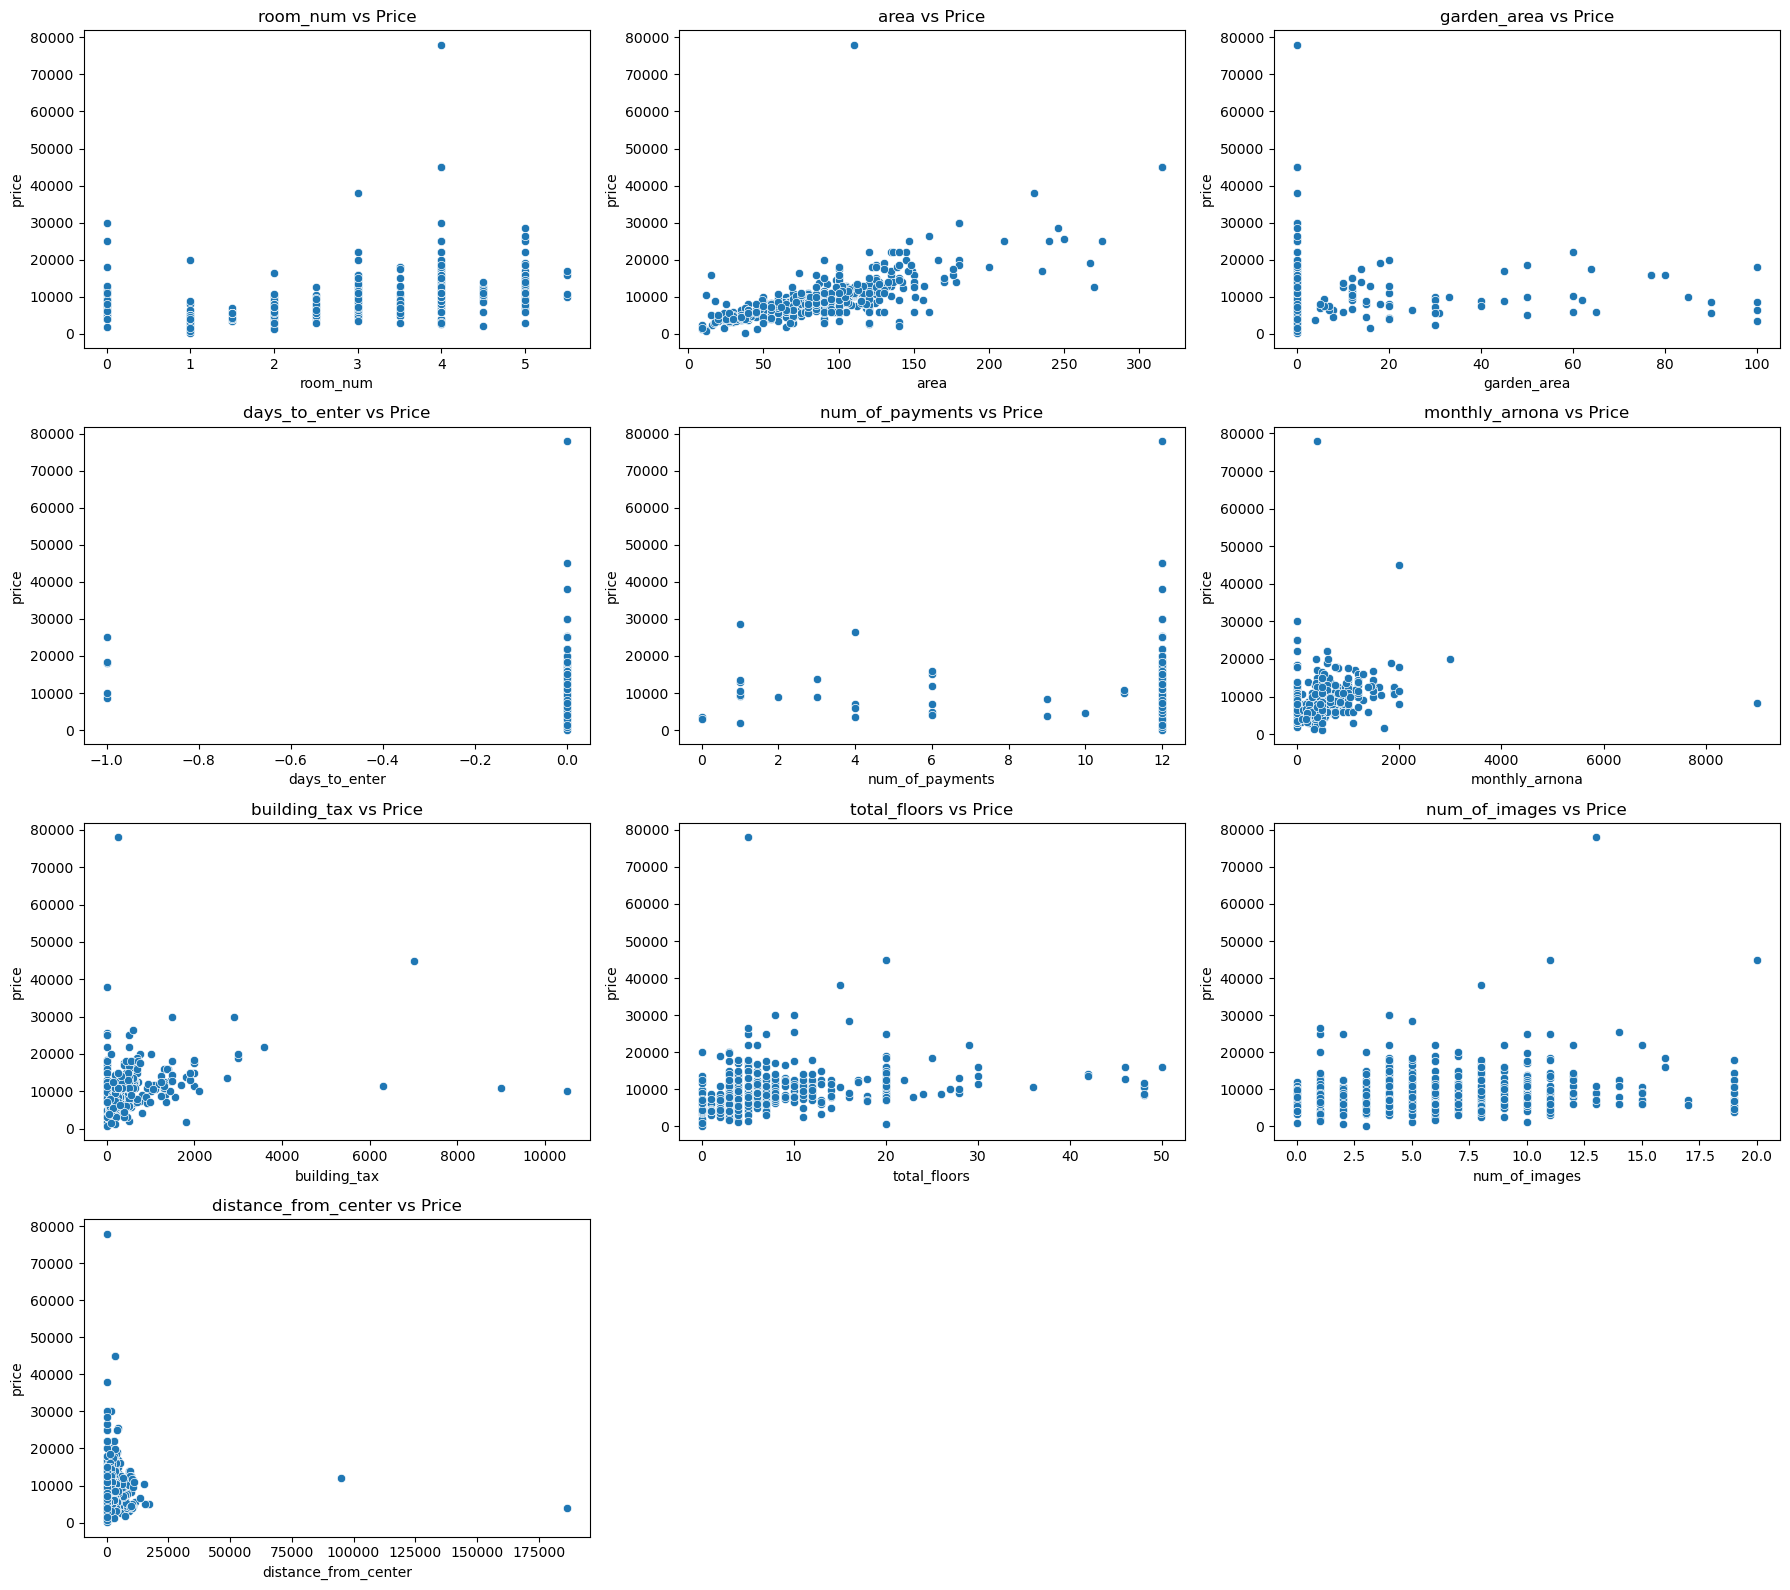

In [9]:
# Outlier cleaning: keeping only values between the 1st and 99th percentiles for each numerical variable.
filtered_dataset = dataset.copy()
for col in ['room_num', 'area', 'garden_area', 'price']:
    q_low = dataset[col].quantile(0.01)
    q_high = dataset[col].quantile(0.99)
    filtered_dataset = filtered_dataset[(filtered_dataset[col] >= q_low) & (filtered_dataset[col] <= q_high)]
cols = 3
numeric_cols = ['room_num', 'area', 'garden_area', 'days_to_enter', 'num_of_payments',
                'monthly_arnona', 'building_tax', 'total_floors', 'num_of_images',
                'distance_from_center']
rows = (len(numeric_cols) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.scatterplot(data=filtered_dataset, x=col, y='price', ax=axes[i])
    axes[i].set_title(f'{col} vs Price')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### the columns

In [10]:
dataset.columns

Index(['property_type', 'neighborhood', 'address', 'room_num', 'floor', 'area',
       'garden_area', 'days_to_enter', 'num_of_payments', 'monthly_arnona',
       'building_tax', 'total_floors', 'description', 'has_parking',
       'has_storage', 'elevator', 'ac', 'handicap', 'has_bars',
       'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
       'num_of_images', 'distance_from_center', 'price'],
      dtype='object')

### the types

In [11]:
dataset.dtypes


property_type            object
neighborhood             object
address                  object
room_num                float64
floor                    object
area                      int64
garden_area             float64
days_to_enter           float64
num_of_payments         float64
monthly_arnona          float64
building_tax            float64
total_floors            float64
description              object
has_parking               int64
has_storage               int64
elevator                  int64
ac                        int64
handicap                  int64
has_bars                  int64
has_safe_room             int64
has_balcony               int64
is_furnished              int64
is_renovated              int64
num_of_images           float64
distance_from_center    float64
price                   float64
dtype: object

### We'll remove missing values from the target column, since we can't perform manipulations on it.


In [12]:
dataset.dropna(subset=['price'], inplace = True)

 ### We'll also remove outliers from it.


In [13]:
Q1 = dataset['price'].quantile(0.25)
Q3 = dataset['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR range: {lower_bound:.0f} - {upper_bound:.0f}")

IQR range: -1500 - 18500


We will leave in the price column only the rows within these ranges (drop outliers)

In [14]:
dataset = dataset[(dataset['price'] >= 1500) & (dataset['price'] <= 18500)]


### We'll remove duplicates.


In [15]:
print('Number of duplicates:', dataset.duplicated().sum())

Number of duplicates: 0


We will fill empty values like quotes in NaN.

In [16]:
dataset.replace({'': np.nan, ' ': np.nan}, inplace=True)

Rows that are missing data in the address column and the neighborhood column

In [17]:
missing_location_df = dataset[dataset["neighborhood"].isna() & dataset["address"].isna()]

# הצגת התוצאה
print(f"🔍 Found {len(missing_location_df)} Rows with missing values in-neighborhood or address")
display(missing_location_df)

🔍 Found 2 Rows with missing values in-neighborhood or address


,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,ac,handicap,has_bars,has_safe_room,has_balcony,is_furnished,is_renovated,num_of_images,distance_from_center,price
371,NaN,NaN,NaN,0.0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,8.0,0.0,10000.0
372,NaN,NaN,NaN,0.0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,5.0,0.0,3799.0


We will remove these lines.

In [18]:
dataset = dataset[~(dataset["neighborhood"].isna() & dataset["address"].isna())].reset_index(drop=True)

### We'll remove rows that contain at most 5 non-null values.


In [19]:
dataset = dataset[dataset.apply(lambda row: (row != 0).sum() > 4, axis=1)]

### The sum of missing values in each column.


In [20]:
dataset.isna().sum().sort_values(ascending = False)

days_to_enter           164
monthly_arnona          136
garden_area             122
building_tax            112
total_floors             39
address                  22
distance_from_center     16
floor                     4
description               4
num_of_payments           3
num_of_images             1
is_furnished              0
has_balcony               0
property_type             0
is_renovated              0
has_bars                  0
has_safe_room             0
has_parking               0
handicap                  0
ac                        0
elevator                  0
has_storage               0
neighborhood              0
area                      0
room_num                  0
price                     0
dtype: int64

The column with the most missing values does not exceed 60%, so no column can be dropped directly due to a high amount of missing values.


## property_type column

In [21]:
dataset['property_type'].unique()

array(['דירה', 'דירת גן', 'דופלקס', 'יחידת דיור', 'גג/פנטהאוז',
       'באתר מופיע ערך שלא ברשימה הסגורה', 'גג/ פנטהאוז', 'דו משפחתי',
       'גג/פנטהאוז להשכרה', 'החלפת דירות', 'כללי', 'סטודיו/לופט',
       'דירה להשכרה', 'מרתף/פרטר', "פרטי/קוטג'", 'סאבלט', 'Квартира',
       'דירת גן להשכרה'], dtype=object)

In [22]:
from collections import Counter

counts = Counter(dataset['property_type'].dropna())
counts

Counter({'דירה': 610,
         'דירת גן': 18,
         'דופלקס': 12,
         'יחידת דיור': 9,
         'גג/פנטהאוז': 23,
         'באתר מופיע ערך שלא ברשימה הסגורה': 1,
         'גג/ פנטהאוז': 9,
         'דו משפחתי': 1,
         'גג/פנטהאוז להשכרה': 2,
         'החלפת דירות': 1,
         'כללי': 14,
         'סטודיו/לופט': 10,
         'דירה להשכרה': 9,
         'מרתף/פרטר': 6,
         "פרטי/קוטג'": 3,
         'סאבלט': 1,
         'Квартира': 1,
         'דירת גן להשכרה': 1})

We standardized `property_type` using keyword rules and description-based inference to fix inconsistencies and fill missing values. This improved data quality and model reliability without losing useful records.


In [23]:
# 🔹 Step 1: Classification based on the 'property_type' column
def classify_property_type(val):
    """
    This function classifies the property type based on keywords found in the 'property_type' field.
    Returns a cleaned category like 'דירה', 'פרטי', 'סאבלט', etc.
    """
    if not isinstance(val, str):
        return np.nan
    val_lower = val.lower()

    if 'סאבלט' in val_lower:
        return 'סאבלט'
    elif 'פרטי' in val_lower or 'קוטג' in val_lower or 'דו משפחתי' in val_lower:
        return 'פרטי'
    elif 'סטודיו' in val_lower or 'לופט' in val_lower:
        return 'סטודיו/לופט'
    elif 'גג' in val_lower or 'פנטהאוז' in val_lower:
        return 'גג/פנטהאוז'
    elif 'דופלקס' in val_lower:
        return 'דופלקס'
    elif 'דירת גן' in val_lower:
        return 'דירת גן'
    elif 'דירה' in val_lower or 'דירת' in val_lower:
        return 'דירה'
    else:
        return np.nan

# 🔹 Step 2: Guess type using 'description' field if 'property_type' is missing or unclear
def guess_type_from_description(desc):
    """
    This function attempts to infer the property type using keywords in the 'description' text,
    especially when the 'property_type' field is missing.
    """
    if pd.isna(desc):
        return np.nan

    desc = desc.lower()

    # Filter out commercial or non-residential listings based on keywords
    non_apartment_keywords = [
        r'משרד', r'משרדים', r'קליניקה', r'גלריה', r'סטודיו לאמן',
        r'חלל עבודה', r'תלת פאזי', r'מחסן', r'סדנה', r'בית מלאכה', r'מסחרי'
    ]
    for pattern in non_apartment_keywords:
        if re.search(rf'\b{pattern}\b', desc):
            return np.nan

    # Match keywords to infer likely residential type
    patterns = [
        (r'\bיחידת דיור\b', 'יחידת דיור'),
        (r'\bסאבלט\b', 'סאבלט'),
        (r'\b(פרטי|קוטג|דו משפחתי)\b', 'פרטי'),
        (r'\b(סטודיו|לופט)\b', 'סטודיו/לופט'),
        (r'\b(גג|פנטהאוז)\b', 'גג/פנטהאוז'),
        (r'\bדופלקס\b', 'דופלקס'),
        (r'\bדירת גן\b', 'דירת גן'),
        (r'\b(דירה|דירת)\b', 'דירה'),
        (r'\bחדר\b', 'דירה'),
        (r'\bבית\b', 'דירה'),
    ]
    for pattern, value in patterns:
        if re.search(pattern, desc):
            return value

    return np.nan

# 🔹 Step 3: Create new column 'property_type_clean' with combined logic

# 1. First classify using the original 'property_type' column
dataset['property_type_clean'] = dataset['property_type'].apply(classify_property_type)

# 2. For rows still missing values, try to guess based on 'description'
missing_mask = dataset['property_type_clean'].isna()
dataset.loc[missing_mask, 'property_type_clean'] = dataset.loc[missing_mask, 'description'].apply(guess_type_from_description)

# 3. Fill in anything still missing with the label 'לא ידוע' (unknown)
dataset['property_type_clean'] = dataset['property_type_clean'].fillna('לא ידוע')

# 🔹 Step 4: Summary – Count how many entries fall into each cleaned category
from collections import Counter
counts = Counter(dataset['property_type_clean'].dropna())
counts


Counter({'דירה': 632,
         'דירת גן': 19,
         'דופלקס': 12,
         'יחידת דיור': 5,
         'גג/פנטהאוז': 34,
         'סטודיו/לופט': 12,
         'פרטי': 5,
         'לא ידוע': 11,
         'סאבלט': 1})

All "unknown" property types are likely not residential rentals, so we removed them to keep the dataset focused and relevant.


In [24]:
dataset[dataset['property_type_clean'] == 'לא ידוע'][['property_type', 'property_type_clean', 'description']]


,property_type,property_type_clean,description
191,כללי,לא ידוע,להשכרה חלל אחד: 37 מטר + קומת גלריה 19 מטר רצפ...
193,כללי,לא ידוע,משרד מפואר עם חלון ענק. קרוב מאוד לאוטובוסים ו...
244,כללי,לא ידוע,"כיכר השעון ביפו , חנות להשכרה במיקום מרכזי על ..."
260,כללי,לא ידוע,NaN
276,מרתף/פרטר,לא ידוע,"המחיר כולל ארנונה, YES, חשמל ומים."
456,מרתף/פרטר,לא ידוע,"[<p class=""text-word-break"">המחיר כולל ארנונה,..."
519,כללי,לא ידוע,"להשכרה חנות מקסימה במיקום מעולה ברחוב בזל בת""א..."
627,כללי,לא ידוע,"בסמוך לרחוב פלורנטין, דירת חדר + גלריה, מוארת ..."
638,מרתף/פרטר,לא ידוע,"המחיר כולל ארנונה, YES, חשמל ומים."
661,כללי,לא ידוע,משרד מפואר עם 3 כיווני אוויר - בדיוק בשפיץ הקד...


We also found a row that was actually a job advertisement, not a rental listing—so we removed it as it wasn't a valid apartment entry.


In [25]:
mask = dataset['description'].str.contains('קורות חיים', case=False, na=False)
cv_ads = dataset[mask][['description', 'property_type', 'property_type_clean']]

print(f"📄 נמצאו {len(cv_ads)} תיאורים הכוללים את הביטוי 'קורות חיים':")
cv_ads.head()

📄 נמצאו 1 תיאורים הכוללים את הביטוי 'קורות חיים':


,description,property_type,property_type_clean
307,🏡💼**דרושים לעבודה ! הזדמנות להרוויח!** 📱💻\nבכת...,פרטי/קוטג',פרטי


In [26]:
# Removing rows that contain 'resume' in the description
dataset = dataset[~dataset['description'].str.contains('קורות חיים', case=False, na=False)]

# Removing rows where the type of apartment is 'unknown'
dataset = dataset[dataset['property_type_clean'] != 'לא ידוע']


The result: a new, clean, and well-classified column for property types.


In [27]:
print(dataset['property_type_clean'].unique())

['דירה' 'דירת גן' 'דופלקס' 'יחידת דיור' 'גג/פנטהאוז' 'סטודיו/לופט' 'פרטי'
 'סאבלט']


In [28]:
#display result
dataset['property_type_clean'].isna().sum()

0

## New Column -street

We'll split the values so we can focus on street names, as they provide more specific information.


In [29]:
# Define a function to split an address string into street name and house number
def split_address(address):
    """
    Splits a full address string into two components: street name and house number.
    If the input is not a string, returns (None, None).

    Example:
        'Dizengoff 123' → ('Dizengoff', '123')
        'Ben Yehuda' → ('Ben Yehuda', None)
    """
    if not isinstance(address, str):
        return pd.Series([None, None])
    
    # Use regex to match non-digit characters (street) followed by optional digits (house number)
    match = re.search(r'(\D+)\s*(\d+)?', address)
    if match:
        street = match.group(1).strip()                  
        number = match.group(2) if match.group(2) else None  
        return pd.Series([street, number])
    
    return pd.Series([None, None])  

# Apply the function to the 'address' column and create new columns: 'street' and 'house_number'
dataset[['street', 'house_number']] = dataset['address'].apply(split_address)

# Preview the resulting columns for the first 5 rows
dataset[['address', 'street', 'house_number']].head(5)



,address,street,house_number
0,"מהר""ל 25","מהר""ל",25
1,ארלוזורוב 35,ארלוזורוב,35
2,וורמיזה 5,וורמיזה,5
3,עמנואל הרומי 30,עמנואל הרומי,30
4,ארלוזורוב 50,ארלוזורוב,50


The house number column is not relevant, doesn't provide much information, and there's no reliable way to fill in the missing values—so we decided to remove it.

In [30]:
dataset= dataset.drop('house_number', axis=1)

We will check for missing values.

In [31]:
dataset['street'].isna().sum()

22

In [32]:
dataset['street'] = dataset['street'].fillna("Unknown")


## floor column

In [33]:
dataset['floor'].unique()

array(['2', '1', '3', '6', '0', '4', '5', '7', '9', '3 מתוך 4',
       '2 מתוך 4', 'קרקע מתוך 4', '2 מתוך 3', '5 מתוך 7', '1 מתוך 4',
       '3 מתוך 6', 'קרקע מתוך קרקע', '3 מתוך 3', 'קרקע מתוך 3',
       '2 מתוך 5', '7 מתוך 20', '3 מתוך 5', '1 מתוך 3', '1 מתוך 5',
       '4 מתוך 6', '10 מתוך 10', '20 מתוך 20', '8', '13', '11', '10',
       '20', '18', '27', '35', '34', '110', '44', '15', '14', '24', '16',
       '45', '610', '17', '12', '19', nan], dtype=object)

For all private houses with no floor information, we set the floor to 0, assuming ground-level entry is typical for such properties.


In [34]:
conditions = (dataset['floor'].isna()) & (dataset['property_type'].isin(['פרטי']))
dataset.loc[conditions, 'floor'] = 0


We created a function that converts textual floor values into standardized numeric values to ensure the data is consistent, accurate, and usable for predictive modeling.


In [35]:
def extract_floor_clean(val):
    
    

    # If the input is missing (NaN), return NaN
    if pd.isna(val):
        return np.nan

    # Convert the value to string and remove leading/trailing spaces
    val = str(val).strip()

    # Handle specific textual cases

    # Case: "Ground out of ground" (e.g., "קרקע מתוך קרקע")
    if val == 'קרקע מתוך קרקע':
        return 0

    # Case: Contains the word "קרקע" (ground floor)
    if 'קרקע' in val:
        return 0

    # Case: Contains the word "מרתף" (basement)
    if 'מרתף' in val:
        return -1

    # Try to extract the first numeric value (floor number)
    match = re.findall(r'\d+', val)
    if match:
        try:
            num = int(match[0])
            # Acceptable floor numbers are in the range 0–100
            if 0 <= num <= 100:
                return num
        except:
            return np.nan

    # If no known pattern is matched, return NaN
    return np.nan


In [36]:
dataset['floor_clean'] = dataset.apply(
    lambda row: extract_floor_clean(row['floor']),
    axis=1
)


In [37]:
dataset[dataset['property_type_clean'] == 'פרטי'][['property_type_clean','floor_clean','total_floors']]


,property_type_clean,floor_clean,total_floors
164,פרטי,0.0,0.0
297,פרטי,0.0,0.0
455,פרטי,3.0,3.0
668,פרטי,0.0,0.0


It makes more sense that if the floor is "ground floor out of ground floor", then the total number of floors should be set to 1.


In [38]:
# Ensure 'floor_clean' column is numeric (convert strings to numbers, coerce errors to NaN)
dataset['floor_clean'] = pd.to_numeric(dataset['floor_clean'], errors='coerce')

# Re-apply the condition after conversion
# If total_floors is 0 and the floor_clean value is 0 or 1, assume the total_floors should be 1
condition = (dataset['total_floors'] == 0) & (dataset['floor_clean'].isin([0, 1]))
updated_count = condition.sum()

# Update the 'total_floors' values to 1 for rows matching the condition
dataset.loc[condition, 'total_floors'] = 1

# Print a summary of how many rows were updated
print(f"✅ Updated {updated_count} rows where 'total_floors' was set to 1 based on 'floor_clean' values after conversion")


✅ Updated 28 rows where 'total_floors' was set to 1 based on 'floor_clean' values after conversion


The new column is clean and structured, but it still contains missing values.


In [39]:
dataset['floor_clean'].unique()

array([ 2.,  1.,  3.,  6.,  0.,  4.,  5.,  7.,  9., 10., 20.,  8., 13.,
       11., 18., 27., 35., 34., nan, 44., 15., 14., 24., 16., 45., 17.,
       12., 19.])

Let's check descriptive statistics for the new column:

In [40]:
print(dataset['floor_clean'].describe())


count    714.000000
mean       4.514006
std        6.252557
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       45.000000
Name: floor_clean, dtype: float64


#### Distribution graph of floor

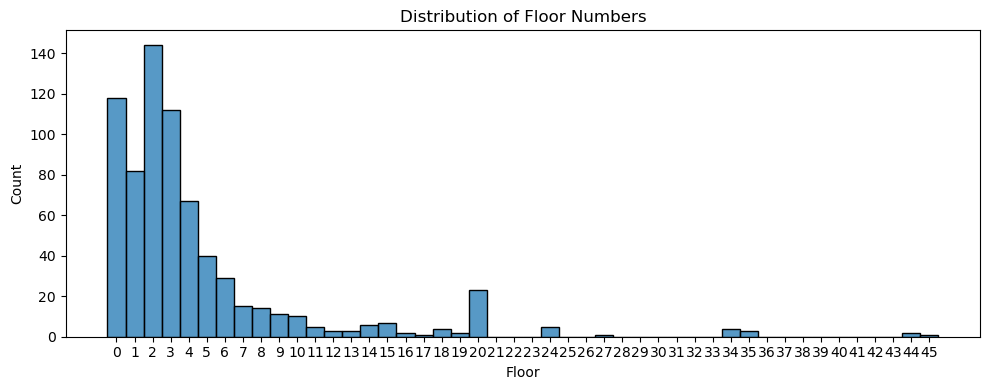

In [41]:


plt.figure(figsize=(10, 4))
sns.histplot(dataset['floor_clean'].dropna(), bins=range(0, 50), discrete=True)
plt.title('Distribution of Floor Numbers')
plt.xlabel('Floor')
plt.ylabel('Count')
plt.xticks(range(0, 46))
plt.tight_layout()
plt.show()


### Let's explore the rows with missing values.


In [42]:
dataset['floor_clean'].isna().sum()

5

In [43]:
dataset.loc[dataset['floor_clean'].isna(), [ 'floor','floor_clean','total_floors', 'property_type', 'address']]


,floor,floor_clean,total_floors,property_type,address
320,110,NaN,10.0,דירה,אסא קדמוני 2
350,610,NaN,10.0,דירה,"מח""ל 9"
427,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14
431,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14
648,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14


We discovered that users were confused and wrote the floor value merged with the total number of floors, as the number matches the total floors and is also smaller than it.


In [44]:
def extract_floor_strict(val, total_floors):
    # If the input is missing, return NaN
    if pd.isnull(val):
        return np.nan

    # Convert value to string and remove leading/trailing spaces
    val = str(val).strip()

    # If the value is '0' or contains the word 'קרקע' (ground), return 1
    if val == '0' or 'קרקע' in val:
        return 1

    # Try to extract the first numeric sequence from the string
    match = re.search(r'\d+', val)
    if not match:
        return np.nan

    num_str = match.group()

    try:
        num = int(num_str)
    except:
        return np.nan

    # If the extracted number is within a valid range (1–100), return it
    if 0 < num <= 100:
        return num

    # If the number is too long and includes total_floors (e.g., '305' means floor 3 out of 5),
    # try to extract the real floor number from the start of the string
    if not pd.isnull(total_floors):
        tf_str = str(int(total_floors))
        if num_str.endswith(tf_str):
            floor_part = num_str[:-len(tf_str)]
            if floor_part.isdigit():
                floor_val = int(floor_part)
                if 0 < floor_val <= 100:
                    return floor_val

    # If no valid floor could be determined, return NaN
    return np.nan


In [45]:
 #Apply the extract_floor_strict function row by row,
# using both 'floor' and 'total_floors' columns as inputs,
# and store the cleaned floor number in a new column called 'floor_clean'
dataset['floor_clean'] = dataset.apply(
   lambda row: extract_floor_strict(row['floor'], row['total_floors']),
   axis=1
)

Displaying the rows with the remaining missing values.


In [46]:
dataset.floor_clean.isna().sum()

3

In [47]:
dataset.loc[dataset['floor_clean'].isna(), [ 'floor','floor_clean','total_floors', 'property_type', 'address','description']]

,floor,floor_clean,total_floors,property_type,address,description
427,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14,מציאת המציאות! דירה מ-ו-ש-ל-מ-ת ומאובזרת במטבח...
431,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14,במגדל חדש והיוקרתי בדה וינצי קומה גבוהה מעל 20...
648,NaN,NaN,NaN,דירה,ליאונרדו דה וינצ'י 14,במגדל חדש והיוקרתי בדה וינצי\r\nקומה גבוהה מעל...


We observed that based on the description, it's possible to fill in the value — for example, if it says "floor above 20", we filled in 21, since we don’t know the exact number but it seems reasonable and not extreme.


In [48]:

def extract_floor_from_description(desc):
    """
    Extracts the floor number from a textual property description.
    Supports various Hebrew patterns like 'קומה 3', 'בקומה 10', 'קומת קרקע', and 'מעל קומה 20'.
    Returns a numeric floor value or NaN if no valid pattern is found.
    """
    if pd.isna(desc):
        return np.nan

    desc = desc.lower()

    # Case 1: Regular floor pattern, e.g., "קומה 3", "בקומה 10", "קומה: 5"
    match = re.search(r'קומ[ה|ת] (?:מס\' )?(\d{1,2})', desc)
    if match:
        return int(match.group(1))

    # Case 2: Pattern like "מעל קומה 20" (meaning "above floor 20") → return 21
    match = re.search(r'מעל.*?(\d{1,2})', desc)
    if match:
        return int(match.group(1)) + 1

    # Case 3: Ground floor (e.g., "קומת קרקע", "קרקע")
    if 'קומת קרקע' in desc or 'קרקע' in desc:
        return 0

    # Default: no match found
    return np.nan


# Save a copy of the original floor_clean column before making any changes
original_floor = dataset['floor_clean'].copy()

# Identify rows with missing floor_clean values
missing_floor_mask = dataset['floor_clean'].isna()

# Attempt to fill missing floor_clean values by extracting info from 'description'
dataset.loc[missing_floor_mask, 'floor_clean'] = dataset.loc[missing_floor_mask, 'description'].apply(extract_floor_from_description)

# Identify which rows were updated
updated_mask = original_floor.isna() & dataset['floor_clean'].notna()
updated_rows = dataset.loc[updated_mask, ['description', 'floor_clean']]

# Report number of successfully extracted floor values
print(f" {len(updated_rows)} rows updated with floor number extracted from description")

# Display a sample of up to 10 updated rows
updated_rows.head(10)


 2 rows updated with floor number extracted from description


,description,floor_clean
431,במגדל חדש והיוקרתי בדה וינצי קומה גבוהה מעל 20...,21.0
648,במגדל חדש והיוקרתי בדה וינצי\r\nקומה גבוהה מעל...,21.0


We will remove rows with missing values.


In [49]:
dataset.dropna(subset=['floor_clean'], inplace = True)
dataset['floor_clean'].isna().sum()

0

#### Boxplot for floor_clean column

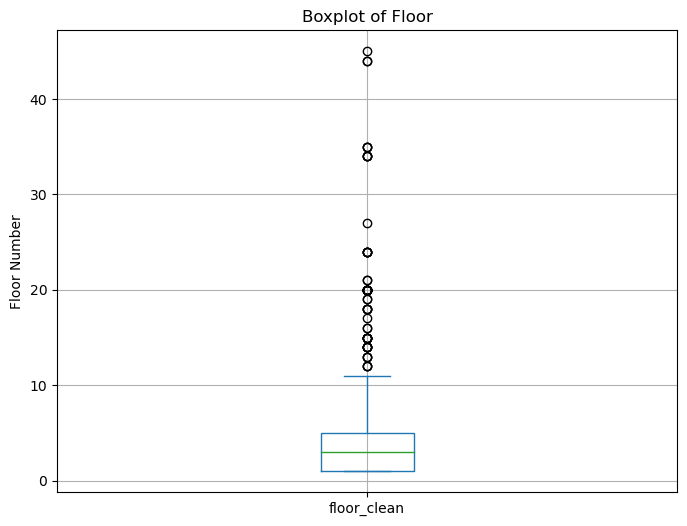

In [50]:
plt.figure(figsize=(8, 6))
dataset['floor_clean'].plot.box()
plt.title("Boxplot of Floor")
plt.ylabel("Floor Number")
plt.grid(True)
plt.show()



Another inconsistency is when the value in the "floor" column is greater than the value in the "total floors" column, which doesn't make sense — so we will check for that.


In [51]:
dataset_ = dataset[
    (dataset['floor_clean'].notna()) &
    (dataset['total_floors'].notna()) &
    (dataset['floor_clean'] > dataset['total_floors'])
][['floor', 'floor_clean', 'total_floors']]

dataset_.head()


,floor,floor_clean,total_floors
316,27,27.0,7.0
317,4,4.0,0.0
318,35,35.0,5.0
319,34,34.0,4.0
321,34,34.0,4.0


We see again that the person filling out the data confused the floor number with the total number of floors. Therefore, to ensure fairness and accuracy, we’ll separate the values — this way we won’t have such outlier values.


In [52]:
def fix_merged_floor(row):
    floor = row['floor_clean']
    total = row['total_floors']
    
    # If both floor and total_floors are available
    if pd.notna(floor) and pd.notna(total):
        # If the floor number is greater than the total number of floors, something may be wrong
        if floor > total:
            # Break the floor number into individual digits
            digits = [int(d) for d in str(int(floor)) if d.isdigit()]
            
            # If total_floors appears inside the digits of floor, remove it
            if int(total) in digits:
                digits.remove(int(total))
                
                # If a valid digit remains, return it as the corrected floor
                if digits:
                    new_floor = digits[0]
                    
                    # Ensure the new floor value is logically valid
                    if new_floor <= total:
                        return new_floor
    # If no correction was made, return the original floor
    return floor


Let's check which rows remain where the total number of floors is less than the floor number:


In [53]:
# Create a mask for rows where total_floors is 0 but the floor number is greater than 0
mask = (dataset['total_floors'] == 0) & (dataset['floor_clean'] > 0)

# Show rows that match the mask, including the original 'elevator' value
print(dataset.loc[mask, ['floor_clean', 'total_floors', 'elevator']])

     floor_clean  total_floors  elevator
317          4.0           0.0         0
322          4.0           0.0         0
325          4.0           0.0         0
326          5.0           0.0         0
327          4.0           0.0         0
332          5.0           0.0         1
339          3.0           0.0         0
340          3.0           0.0         0
342          4.0           0.0         0
346          4.0           0.0         0
347          5.0           0.0         0
349          4.0           0.0         0


<!-- We chose to update the `total_floors` value based on the `floor_clean` value in cases where `total_floors` was zero but a valid floor number was provided. The reasoning is that a building is unlikely to have a positive floor value without any total floors specified. Therefore, we reasonably assumed that the given floor is also the total number of floors. This approach preserves important information and prevents the loss of valuable data for prediction.
 -->

## total_floors column

display unique list of the values

In [54]:
dataset['total_floors'].unique()

array([ 4.,  3.,  5.,  7.,  2.,  1.,  6.,  9., 11., 10., 12.,  8., 23.,
       24., 14., nan, 16., 13., 26., 27., 30., 15., 20., 28., 18., 22.,
        0., 25., 44., 40., 49., 46., 50., 35., 17., 48., 36., 42.])

A missing value was assigned to all rows where the total number of floors was smaller than the floor number.


In [55]:
# Create a mask where floor_clean is greater than total_floors,
# and both values are not NaN (i.e., are available)
mask = (
    (dataset['floor_clean'] > dataset['total_floors']) &
    (dataset['floor_clean'].notna()) &
    (dataset['total_floors'].notna())
)

# Set total_floors to NaN for the mismatched rows
dataset.loc[mask, 'total_floors'] = np.nan

# Print how many rows were updated
print(f"✅ {mask.sum()} rows updated: total_floors set to NaN due to conflict with floor_clean")


✅ 34 rows updated: total_floors set to NaN due to conflict with floor_clean


Current number of missing values.


In [56]:
dataset['total_floors'].isna().sum()

70

A function that extracts total floors and floor number from the description (X out of Y).


In [57]:
def extract_total_floors_from_floor(val):
    """
    Extracts the total number of floors in a building from a floor description string.
    Returns the total floors as an integer, or NaN if it can't be extracted.
    Handles formats like:
    - 'קרקע מתוך 3'
    - '2 מתוך 5'
    - 'קרקע מתוך קרקע'
    """
    if pd.isna(val):
        return np.nan

    val = str(val).strip()

    # Case: "Ground out of ground" → building has 1 floor
    if val == 'קרקע מתוך קרקע':
        return 1

    # Case: "Ground out of X" (e.g., 'קרקע מתוך 3') → return X
    if 'קרקע מתוך' in val:
        match = re.search(r'קרקע מתוך (\d+)', val)
        if match:
            return int(match.group(1))
        else:
            return np.nan

    # General case: "Y out of Z" (e.g., 'קומה 2 מתוך 5') → return Z (the last number)
    match = re.findall(r'\d+', val)
    if len(match) >= 2:
        return int(match[-1])  # last number assumed to be total floors

    return np.nan


In [58]:
# Create a mask to identify rows where total_floors is missing
mask_missing = dataset['total_floors'].isna()

# For those rows, try to extract total floors from the original 'floor' column
dataset.loc[mask_missing, 'total_floors'] = dataset.loc[mask_missing, 'floor'].apply(extract_total_floors_from_floor)

# Convert the total_floors column to float (ensures consistency and allows NaNs)
dataset['total_floors'] = dataset['total_floors'].astype(float)


Current number of missing values.


In [59]:
dataset['total_floors'].isna().sum()

41

Let's check descriptive statistics for the new column:

In [60]:
print(dataset['total_floors'].describe())


count    677.000000
mean       8.350074
std        9.539860
min        1.000000
25%        4.000000
50%        5.000000
75%        8.000000
max       50.000000
Name: total_floors, dtype: float64


In [61]:
#Create a new DataFrame containing rows where total_floors is still missing
# and select relevant columns for inspection
missing_total_floors = dataset[dataset['total_floors'].isna()][[
    'floor_clean', 'total_floors', 'property_type_clean', 'elevator', 'building_tax'
]]

# Display the first few rows of the result
missing_total_floors.head()

,floor_clean,total_floors,property_type_clean,elevator,building_tax
235,1.0,NaN,סטודיו/לופט,0,NaN
236,1.0,NaN,סטודיו/לופט,0,NaN
316,27.0,NaN,דירה,1,200.0
317,4.0,NaN,דירה,0,200.0
318,35.0,NaN,דירה,1,330.0


In [62]:
# Filter rows where total_floors is missing (NaN)
# but building_tax is present (not NaN)
missing_total_floors_with_tax = dataset[
    dataset['total_floors'].isna() & dataset['building_tax'].notna()
][[
    'floor_clean', 'total_floors', 'property_type_clean', 'elevator', 'building_tax'
]]

# Display the first few matching rows
missing_total_floors_with_tax.head()


,floor_clean,total_floors,property_type_clean,elevator,building_tax
316,27.0,NaN,דירה,1,200.0
317,4.0,NaN,דירה,0,200.0
318,35.0,NaN,דירה,1,330.0
319,34.0,NaN,סאבלט,1,0.0
321,34.0,NaN,דירה,1,0.0


 This code fills missing values in the 'total_floors' column using a smart strategy:
It calculates median total_floors based on similar properties (same elevator status, parking, and building_tax level),
 and ensures the result is not lower than the known floor number ('floor_clean') if available.


In [63]:
#  Create temporary quantile-based categories for building tax
dataset['_building_tax_bin'] = pd.qcut(dataset['building_tax'], q=4, duplicates='drop')

#  Calculate the median of total_floors for each group 
# grouped by elevator availability, parking availability, and tax bin
group_median = dataset.groupby(['elevator', 'has_parking', '_building_tax_bin'])['total_floors'].median()

#  Define a smart imputation function for missing total_floors
def smart_fill(row):
    # If value is already available, return it
    if pd.notna(row['total_floors']):
        return row['total_floors']
    
    # Try to use the precomputed group median
    try:
        group_value = group_median.loc[row['elevator'], row['has_parking'], row['_building_tax_bin']]
    except:
        # If no matching group, fall back to overall median
        group_value = dataset['total_floors'].median()
    
    # If floor_clean is known, ensure total_floors is at least that floor number
    if pd.notna(row.get('floor_clean')):
        return max(group_value, row['floor_clean'])
    
    return group_value

#  Apply the smart imputation function to each row in the dataset
dataset['total_floors'] = dataset.apply(smart_fill, axis=1)

#  Remove the temporary tax bin column used for grouping
dataset.drop('_building_tax_bin', axis=1, inplace=True)

#  Report how many missing values remain in total_floors
print(f" Remaining missing values in total_floors: {dataset['total_floors'].isna().sum()}")


 Remaining missing values in total_floors: 0


Display sum of missing values

In [64]:
dataset['total_floors'].isna().sum()

0

## garden_area column

Display list of unique values

In [65]:
dataset['garden_area'].unique()

array([ nan,  40.,  20.,  30.,   4.,  60.,   0.,   6.,  12.,  10.,   8.,
        45.,  14.,  50.,  15.,  33.,  62.,   7.,  90., 140.,  31.,  18.,
       100., 200.,  77.,  80.,  16., 120.,  65.,   5.,  64.,  25.,  42.,
       150.,  85.])

Display sum of missing values

In [66]:
dataset['garden_area'].isna().sum()

121

We will investigate rows with missing values where the description mentions something about garden area.


In [67]:

# Filter rows where 'garden_area' is missing
# and the description contains the word "מרפסת" (balcony) or "גינה" (garden)
mask = (
    dataset['garden_area'].isna() &
    dataset['description'].str.contains(r'\b(מרפסת|גינה)\b', case=False, na=False)
)

# Display the first few relevant rows showing the 'description' and 'area' columns
dataset[mask][['description', 'area']].head()



C:\Users\ngr25\AppData\Local\Temp\ipykernel_38764\103810125.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  dataset['description'].str.contains(r'\b(מרפסת|גינה)\b', case=False, na=False)


,description,area
0,בנין ברמה יוצאת דופן. בידוד רעש מעולה. עם חניה...,71
6,רחוב: בגורדון \nבקרבת דיזנגוף מיקום פנטסטי.\nק...,100
8,דירת 3 חדרים חדשה גדולה ומרווחת בבניין חדש במי...,87
12,ברחוב וייזל המבוקש\n\nבקרבת שדרות בן גוריון המ...,70
17,רחוב: א.ד גורדון\n\nהצפון הישן \n\nדירה של 3 ח...,70


First, we'll fill in the values using the description and verify that the information is indeed accurate and consistent.


This function extracts missing garden area values (garden_area) from the property's text description. It searches for phrases like “גינה 30 מ"ר” (garden 30 sqm), validates the extracted number is within a reasonable range (1–300 sqm), and fills in the value in a new column called garden_area_filled. It then reports how many values were successfully filled.

In [68]:
# Function to extract garden area from the 'description' text
def extract_garden_area(desc):
    if pd.isna(desc):
        return np.nan
    desc = desc.replace(',', '')  # Remove commas from numbers
    match = re.search(r'גינה[^0-9]{0,10}(\d{1,4}) ?מ"ר', desc)  # Regex to find garden area in square meters
    if match:
        try:
            area = int(match.group(1))
            # Only return if within a reasonable garden size
            if 1 <= area <= 300:  
                return area
        except:
            return np.nan
    return np.nan

# Create a new column to preserve the original 'garden_area' values
dataset['garden_area_filled'] = dataset['garden_area']

# Identify rows where garden area is missing
missing_mask = dataset['garden_area'].isna()

# Apply extraction function on descriptions to fill missing values
dataset.loc[missing_mask, 'garden_area_filled'] = dataset.loc[missing_mask, 'description'].apply(extract_garden_area)

# Identify rows that were successfully filled from description
updated_mask = dataset['garden_area'].isna() & dataset['garden_area_filled'].notna()
filled_rows = dataset[updated_mask][['description', 'garden_area_filled']]

# Print how many values were filled and show a sample
print(f"✅ {len(filled_rows)} missing values in 'garden_area' were filled based on the description:")
print(filled_rows.head(10))  # Show only the first 10 filled rows


✅ 0 missing values in 'garden_area' were filled based on the description:
Empty DataFrame
Columns: [description, garden_area_filled]
Index: []


Display sum of missing values

In [69]:
dataset['garden_area_filled'].isna().sum()

121

Let's look at the statistics of the column.


In [70]:
print(dataset['garden_area_filled'].describe())


count    597.000000
mean       4.847571
std       18.953100
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      200.000000
Name: garden_area_filled, dtype: float64


### We will create a condition based on the following characteristics:

* The apartment is on a relatively high floor (`floor_clean > 3`)
* The apartment does **not** have a balcony (`has_balcony == 0`)
* The property type is either 'דירה' (apartment) or 'דופלקס' (duplex), and **not** a garden apartment or private house

Only when **all three conditions** are met, we can reasonably assume that the property does not have a garden, and therefore missing (`NaN`) values are replaced with 0.


In [71]:
# Create a mask to identify rows where:
# 1. garden_area_filled is still missing
# 2. The apartment is above the 3rd floor
# 3. The apartment does not have a balcony
# 4. The property type is either 'דירה' (apartment) or 'דופלקס' (duplex)
mask = (
    dataset['garden_area_filled'].isna() &
    (dataset['floor_clean'] > 3) &
    (dataset['has_balcony'] == 0) &
    (dataset['property_type_clean'].isin(['דירה', 'דופלקס']))
)

# For the selected rows, assume garden area is 0 (no garden likely at higher floors without a balcony)
dataset.loc[mask, 'garden_area'] = 0



We decided that if it's not mentioned in the description and there is no value, it's likely there is no garden.


In [72]:
dataset['garden_area_filled'] = dataset['garden_area_filled'].fillna(0)


## New column -garden_size_category

### Categorization of sizes


In [73]:
def categorize_garden_area(x):
    if pd.isna(x):
        return 'לא ידוע'
    elif x == 0:
        return 'אין גינה'
    elif x <= 20:
        return 'קטנה'
    elif x <= 50:
        return 'בינונית'
    else:
        return 'גדולה'

dataset['garden_size_category'] = dataset['garden_area'].apply(categorize_garden_area)


In [74]:
# Display categorys
dataset['garden_size_category'].value_counts()


אין גינה    525
לא ידוע     121
קטנה         37
גדולה        19
בינונית      16
Name: garden_size_category, dtype: int64

## room_num column

In [75]:
# Unique values that we have in the column
dataset['room_num'].unique()

array([3. , 2.5, 2. , 4. , 3.5, 1. , 4.5, 5. , 5.5, 7. , 6. , 1.5, 0. ])

In [76]:
# If the number of rooms is 0, then we will make it NaN.
dataset['room_num'] = dataset['room_num'].replace(0, np.nan)

In [77]:
dataset['room_num'].describe()

count    683.000000
mean       3.152269
std        1.067834
min        1.000000
25%        2.500000
50%        3.000000
75%        4.000000
max        7.000000
Name: room_num, dtype: float64

In [78]:
# It seems we have some NaN.
dataset['room_num'].isna().sum()

35

A function that extracts the number of rooms from the description when the 'number of rooms' column has a missing value.


In [79]:
# Function to extract the number of rooms from a Hebrew text description
def extract_room_num_from_description(description):
    if pd.isnull(description):
        return np.nan

    description = str(description).strip()

    # Mapping Hebrew number words to numeric values
    hebrew_numbers = {
        'חדר אחד': 1,
        'חדר וחצי': 1.5,
        'חדרים וחצי': 1.5,
        'שניים': 2,
        'שני': 2,
        'שתי': 2,
        'שלושה': 3,
        'שלוש': 3,
        'ארבעה': 4,
        'ארבע': 4,
        'חמישה': 5,
        'חמש': 5,
        'שישה': 6,
        'שש': 6,
        'שבעה': 7,
        'שבע': 7,
        'שמונה': 8,
        'תשעה': 9,
        'תשע': 9,
        'עשרה': 10
    }

    # 1. Try matching standard patterns like "3 חדרים" or "כוללת 2.5 חדרים"
    match = re.search(r'(?:דירת|כוללת)?\s*(\d(?:[.,]\d)?)\s*חדרים?', description)
    if match:
        try:
            return float(match.group(1).replace(',', '.'))
        except:
            return np.nan

    # 2. Fallback: match number before the word "חדר"
    match = re.search(r'(\d(?:[.,]\d)?)\s*חדר', description)
    if match:
        try:
            return float(match.group(1).replace(',', '.'))
        except:
            return np.nan

    # 3. Match Hebrew words that describe room numbers
    for word_form, number in hebrew_numbers.items():
        if re.search(rf'{word_form}\s*חדר', description):
            return number

    # 4. If the word "חדר" appears without a number, assume it means 1 room
    if re.search(r'\bחדר\b', description):
        return 1

    return np.nan


In [80]:
#  Fill missing 'room_num' values based on text descriptions

# Extract room numbers from the 'description' column using the custom function
dataset['room_num_from_desc'] = dataset['description'].apply(extract_room_num_from_description)

# Save the original 'room_num' values to identify which rows will be updated
before_fill = dataset['room_num'].copy()

# Define a condition:
# Fill only where 'room_num' is missing AND a valid number was extracted from the description
condition = (
    dataset['room_num'].isna() &                        
    dataset['room_num_from_desc'].notna() &             
    (dataset['room_num_from_desc'] != 0)                
)

# Apply the extracted values to the 'room_num' column where the condition is met
dataset.loc[condition, 'room_num'] = dataset.loc[condition, 'room_num_from_desc']

# Print a summary of how many values were filled
filled_count = condition.sum()
print(f"Number of 'room_num' values filled from description: {filled_count}")


Number of 'room_num' values filled from description: 28


In [81]:
# Display missing values
dataset['room_num'].isna().sum()


7

In [82]:
# Droping missing values
dataset.dropna(subset='room_num',axis=0,inplace=True)

## area column

In [83]:
dataset['area'].unique()

array([ 71,  70,  65,  40, 120, 100,  75,  87,  95,  85,  52,  89,  90,
        60,  80,  78,  58,  50,  68,  55,  42,  27,  30, 104, 110,  38,
        53,  76,  83,  47, 118, 125, 102, 130, 112, 149, 150, 140, 143,
       115,  35,  72, 105,  94, 336,  98,  25, 146,  67, 116, 145,  74,
        48,  93, 108, 103, 151,  88, 270,  66, 122,  36,  77, 156,  54,
        92,  32, 117, 124, 235, 106, 135,  45, 600,  22,  57,  26, 200,
       148, 385, 107,  84,  64, 101, 113,  28, 178, 123,  62,  69,  99,
       133,  96, 250, 132, 153,  15, 176, 127,  20,  16,  24,  59, 142,
        12, 136, 139, 170,  63, 180,  79, 111,   6,  23, 157,  82, 800,
        18,  97, 160, 329, 950,  49,  81], dtype=int64)

In [84]:
dataset['area'].describe()


count    711.000000
mean      88.232068
std       60.223676
min        6.000000
25%       60.000000
50%       80.000000
75%      104.000000
max      950.000000
Name: area, dtype: float64

In [85]:
# 📊 Calculate Quartiles and IQR for the 'area' column
Q1 = dataset['area'].quantile(0.25)  # First quartile (25th percentile)
Q3 = dataset['area'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1                        # Interquartile Range (IQR)

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print the IQR range for reference
print(f"IQR range: {lower_bound:.0f} - {upper_bound:.0f}")

# Identify outliers: area < 15 sqm or area > upper IQR bound
mask_outliers = (dataset['area'] < 15) | (dataset['area'] > upper_bound)

# Mark outliers as NaN for further handling
dataset.loc[mask_outliers, 'area'] = np.nan

# Print how many values were marked as outliers
print(f"✅ Marked {mask_outliers.sum()} outlier values as NaN in the 'area' column")


IQR range: -6 - 170
✅ Marked 18 outlier values as NaN in the 'area' column


 Calculating the median area for each number of rooms


In [86]:
# Step 1: Compute the median area for each room count
# This creates a mapping: for each value of 'room_num', what is the median 'area'
median_area_by_room = dataset.groupby('room_num')['area'].median()

#  Step 2: Fill missing 'area' values
# If 'area' is missing (NaN), fill it with the median area for that room count
dataset['area'] = dataset.apply(
    lambda row: median_area_by_room[row['room_num']] if pd.isna(row['area']) else row['area'],
    axis=1
)


#### Boxplot of area

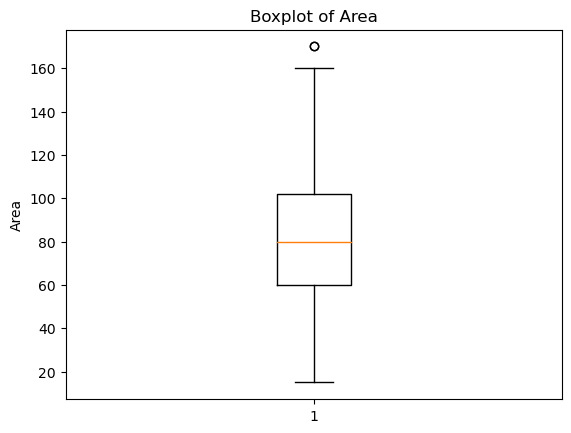

In [87]:
plt.boxplot(dataset['area'].dropna())
plt.title("Boxplot of Area")
plt.ylabel("Area")
plt.show()

## building_tax column

In [88]:
dataset['building_tax'].unique()

array([  614.,   190.,   150.,   100.,    50.,   350.,   250.,    nan,
         525.,    80.,   200.,   360.,   195.,   260.,   300.,    90.,
          60.,   450.,   280.,   230.,   376.,   400.,   120.,     0.,
         420.,   575.,   490.,   725.,   600.,   650.,   690.,   520.,
        6300.,   630.,   550.,   170.,   500.,    20.,   320.,   470.,
          25.,  1500.,   435.,   750.,  2000.,   180.,   949.,   335.,
          65.,    70.,    45.,  1100.,  1300.,   800.,  1320.,    33.,
         390.,   274.,  1200.,   515.,   380.,  1000.,   430.,   700.,
          40.,   570.,   802.,  1850.,   270.,   870.,  1250.,   980.,
         930.,  1800.,  2100.,  1400.,   357.,  2300.,  4000.,  3000.,
        3200.,  2409.,  1580.,  1700.,  1450.,  1240.,  2740.,  1370.,
        1900., 10500.,  9000.,  1080.,   453.,   240.,   160.,   950.,
         920.,   900.,  1570.,  1350.,   715.,   110.,   105.,   140.,
         220.,   196.,   384.,   460.,   495.,  1050.,   210.,   558.,
      

In [89]:
# Display missing values
dataset['building_tax'].isna().sum()


105

In [90]:
dataset['building_tax'].describe()


count      606.000000
mean       481.394389
std        946.224720
min          0.000000
25%        150.000000
50%        250.000000
75%        450.000000
max      10500.000000
Name: building_tax, dtype: float64

Based on the distribution of `building_tax` values, we determined that values below 50 NIS (excluding 0) and above 1,500 NIS are unrealistic or outliers. Therefore, these values were converted to `NaN` for further imputation.


In [91]:
#  Step 1: Calculate IQR bounds for identifying outliers in 'building_tax'
Q1 = dataset['building_tax'].quantile(0.25)  
Q3 = dataset['building_tax'].quantile(0.75)  
IQR = Q3 - Q1                               
upper_bound = Q3 + 1.5 * IQR                 
lower_bound = 0                              

# Print the logical IQR range
print(f"IQR range (logical upper bound): {lower_bound:.0f} - {upper_bound:.0f}")

# 🎯 Step 2: Mark extreme values as NaN
# High outliers: mark values greater than 1500 NIS as NaN
high_outliers_mask = dataset['building_tax'] > 1500
dataset.loc[high_outliers_mask, 'building_tax'] = np.nan

# Low outliers: mark values less than 50 (but not 0) as NaN
low_outliers_mask = (dataset['building_tax'] < 50) & (dataset['building_tax'] != 0)
dataset.loc[low_outliers_mask, 'building_tax'] = np.nan

# 🧾 Step 3: Reporting how many values were affected
total_outliers = high_outliers_mask.sum() + low_outliers_mask.sum()
print(f"✅ Marked {total_outliers} values as NaN in the 'building_tax' column (low and high outliers)")


IQR range (logical upper bound): 0 - 900
✅ Marked 41 values as NaN in the 'building_tax' column (low and high outliers)


We decided that if the property type is a private ground-level house, its building tax will be set to zero since such properties typically don’t have building maintenance fees.


In [92]:
mask = dataset['property_type_clean'] == 'פרטי'
dataset.loc[mask, 'building_tax'] = 0

# Print how many rows were updated
print(f"✅ Updated {mask.sum()} rows: set 'building_tax' to 0 for private properties")


✅ Updated 4 rows: set 'building_tax' to 0 for private properties


## New column building_tax_category column

In [93]:
# Function to categorize building tax into labeled groups
def categorize_building_tax(value):
    if pd.isna(value):
        return "לא יודע"  # "Unknown" for missing values
    elif 0 <= value < 500:
        return "זול"      # "Low" tax category
    elif 500 <= value < 1000:
        return "ממוצע"   # "Medium" tax category
    elif 1000 <= value <= 1500:
        return "גבוה"    # "High" tax category
    else:
        return "לא ידוע"  # Catch-all for unexpected values

# Apply the categorization function to the building_tax column
dataset["building_tax_category"] = dataset["building_tax"].apply(categorize_building_tax)

# Convert the result to a categorical data type for efficiency and clarity
dataset["building_tax_category"] = dataset["building_tax_category"].astype("category")



In [94]:
# Display categorys
dataset["building_tax_category"].unique()

['ממוצע', 'זול', 'לא יודע', 'גבוה']
Categories (4, object): ['גבוה', 'זול', 'לא יודע', 'ממוצע']

We'll try to extract information about building maintenance fees from the description.


In [95]:
# Enhanced function to extract building tax values from the description text
def extract_building_tax(desc):
    if pd.isna(desc):
        return np.nan

    # Remove commas from numbers for easier parsing
    desc = desc.replace(',', '')

    # Regular expression patterns to identify building tax mentions in various formats
    patterns = [
        r'מיס[י|י] [ה]?בנ[יי]ן[^0-9]{0,10}(\d{2,5})',  # Matches "מיסי בניין" with optional variations
        r'ועד[^0-9]{0,10}(\d{2,5})',                   # Matches "ועד הבית" with numbers
        r'עד בנ[יי]ן[^0-9]{0,10}(\d{2,5})',            # Matches slightly misspelled/abbreviated forms
    ]

    # Try each pattern to extract a valid numeric tax amount
    for pattern in patterns:
        match = re.search(pattern, desc)
        if match:
            try:
                value = int(match.group(1))
                if 0 < value < 3000:  # Only accept reasonable values
                    return value
            except:
                return np.nan
    return np.nan

# Filter for rows where building_tax is missing
missing_mask = dataset['building_tax'].isna()

# Attempt to extract building tax from the 'description' column where missing
dataset.loc[missing_mask, 'building_tax'] = dataset.loc[missing_mask, 'description'].apply(extract_building_tax)

# Show how many missing values were filled from the description
filled_rows = dataset[missing_mask & dataset['building_tax'].notna()]
print(f"✅ {len(filled_rows)} missing values in 'building_tax' were filled from the description")


✅ 5 missing values in 'building_tax' were filled from the description


To impute missing values in the `building_tax` column, we applied a smart hierarchical filling strategy based on features with high correlation, such as parking availability, total number of floors, and presence of a safe room. When those were not sufficient, we used median values based on property type and neighborhood, assuming these categorical factors influence building taxes. If no relevant group was found, the overall median of the column was used. This approach balances statistical accuracy with domain-specific logic.


In [96]:
# 1. Create a temporary column with rounded floor count (to assist grouping by floor count)
dataset['total_floors_round'] = dataset['total_floors'].round()

# 2. Calculate group-wise medians for building_tax
# Group 1: Based on parking, rounded total floors, and safe room presence
group1 = dataset.groupby(['has_parking', 'total_floors_round', 'has_safe_room'])['building_tax'].median()

# Group 2: Based on property type and neighborhood
group2 = dataset.groupby(['property_type_clean', 'neighborhood'])['building_tax'].median()

# 3. Initialize counters to monitor how many values are filled using each method
method_counts = {'group1': 0, 'group2': 0, 'fallback': 0}

# 4. Define a smart filling function for missing building_tax values
def fill_building_tax(row):
    # If value already exists, return it
    if pd.notna(row['building_tax']):
        return row['building_tax']
    
    # Try filling from Group 1
    try:
        val = group1.loc[row['has_parking'], row['total_floors_round'], row['has_safe_room']]
        if pd.notna(val):
            method_counts['group1'] += 1
            return val
    except:
        pass

    # If Group 1 fails, try Group 2
    try:
        val = group2.loc[row['property_type_clean'], row['neighborhood']]
        if pd.notna(val):
            method_counts['group2'] += 1
            return val
    except:
        pass

    # Fallback: use overall median if no group match found
    method_counts['fallback'] += 1
    return dataset['building_tax'].median()

# 5. Apply the smart filling function to all rows in the dataset
dataset['building_tax'] = dataset.apply(fill_building_tax, axis=1)

# 6. Remove the temporary rounded total_floors column
dataset.drop('total_floors_round', axis=1, inplace=True)

# 7. Print summary report of how many values were filled by each method
print("\n✅ Summary of filling missing values in 'building_tax':")
print(f"📊 Filled using group1 (parking + floors + safe_room): {method_counts['group1']}")
print(f"🏘️ Filled using group2 (property_type + neighborhood): {method_counts['group2']}")
print(f"📉 Filled using fallback (global median): {method_counts['fallback']}")



✅ Summary of filling missing values in 'building_tax':
📊 Filled using group1 (parking + floors + safe_room): 117
🏘️ Filled using group2 (property_type + neighborhood): 11
📉 Filled using fallback (global median): 9


In [97]:
#Display missing values
dataset['building_tax'].isnull().sum()

0

#### Boxplot of Building Tax

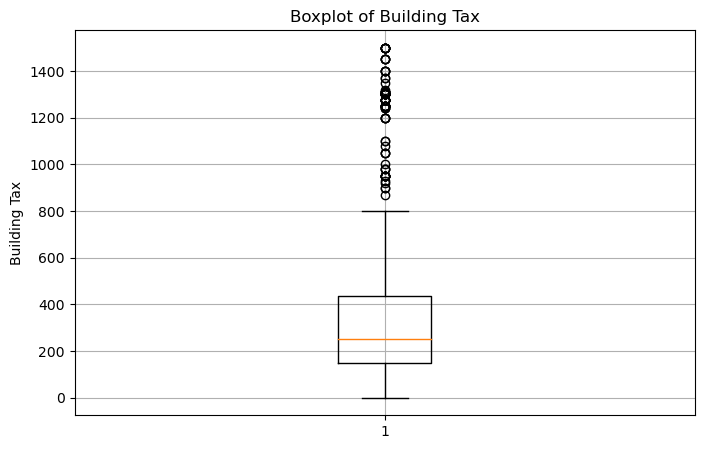

In [98]:
plt.figure(figsize=(8, 5))
plt.boxplot(dataset['building_tax'].dropna())
plt.title('Boxplot of Building Tax')
plt.ylabel('Building Tax')
plt.grid(True)
plt.show()

## monthly_arnona column

In [99]:
dataset['monthly_arnona'].unique()


array([ 467.,  240.,  400.,  100.,  250.,  600.,  500.,   nan,  475.,
        650.,  750.,  450.,  900., 1000.,  700.,  300.,  800.,  850.,
       1200.,  550.,  399., 1100.,  350.,  380.,  490.,  275.,  990.,
        950., 1500., 1900.,  480.,  465.,  200.,  390.,    0., 2000.,
        225.,  780.,  150.,  230.,  556.,  452.,  280.,  160., 1300.,
        358.,  260.,  165.,  220.,  940.,  890., 9000., 1150.,  790.,
       2600., 1650.,  886.,  460., 1600.,  325., 1800.,   90.,  730.,
        175.,  130.,  525.,  515.,  395.,  965., 1450., 1400.,  625.,
        760., 1700.,  675.,  361.,  285.,  560.,  375.,  298.,  309.,
        744.,  210.,  180.,  120.,  110.,  503., 1040.])

In [100]:
dataset['monthly_arnona'].isna().sum()


130

A value of 0 for arnona (municipal tax) is not realistic, so we will convert it to NaN.


In [101]:
dataset.loc[dataset['monthly_arnona'] == 0, 'monthly_arnona'] = np.nan


Statistical description of the column


In [102]:
dataset['monthly_arnona'].describe()


count     494.000000
mean      638.080972
std       546.409807
min        90.000000
25%       352.000000
50%       500.000000
75%       800.000000
max      9000.000000
Name: monthly_arnona, dtype: float64

Outliers


In [103]:
Q1 = dataset['monthly_arnona'].quantile(0.25)
Q3 = dataset['monthly_arnona'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")



Q1: 352.0, Q3: 800.0, IQR: 448.0
Lower Bound: -320.0, Upper Bound: 1472.0


What seemed unusual or illogical was converted to NaN.


In [104]:
#The conversion of property tax values that are too low to NAN.
dataset.loc[dataset['monthly_arnona'] < 100, 'monthly_arnona'] = np.nan
dataset.loc[dataset['monthly_arnona'] > 5000, 'monthly_arnona'] = np.nan

In [105]:
#Display the the missing values
dataset['monthly_arnona'].isna().sum()


219

To handle missing values in the monthly_arnona column, we applied a context-aware method. Instead of using a global average, we searched for similar apartments based on:

Same neighborhood

Similar area (±5 sqm)

Similar number of rooms (±1)

If matching entries were found, we filled the missing value using their average. Otherwise, the value remained missing.



In [106]:
# Function to fill missing values in the 'monthly_arnona' (monthly property tax) column
def fill_missing_arnona(row):
    # If the value already exists, return it as is
    if pd.notna(row['monthly_arnona']):
        return row['monthly_arnona']
    
    # Define a range for area and room number to find similar apartments
    area_min = row['area'] - 5
    area_max = row['area'] + 5
    rooms_min = row['room_num'] - 1
    rooms_max = row['room_num'] + 1

    # Filter the dataset to find similar listings in the same neighborhood
    similar = dataset[
        (dataset['neighborhood'] == row['neighborhood']) &           # Same neighborhood
        (dataset['area'] >= area_min) & (dataset['area'] <= area_max) &  # Similar area range
        (dataset['room_num'] >= rooms_min) & (dataset['room_num'] <= rooms_max) &  # Similar number of rooms
        (dataset['monthly_arnona'].notna())  # Exclude listings with missing arnona
    ]

    # If similar listings were found, return the average monthly arnona of those
    if not similar.empty:
        return similar['monthly_arnona'].mean()
    else:
        return np.nan  # If no match found, return NaN


In [107]:
#Activating the function
dataset['monthly_arnona'] = dataset.apply(fill_missing_arnona, axis=1)
print("Missing values in monthly_arnona:", dataset['monthly_arnona'].isna().sum())

Missing values in monthly_arnona: 138


This function fills missing values in the monthly_arnona column by checking for similar entries:

First by street (if there are at least 3 valid entries),

Then by neighborhood (again, if at least 3 valid entries exist).
If neither condition is met, it returns NaN. This method helps preserve location-based tax patterns.

In [108]:
# Function to fill missing 'monthly_arnona' (monthly property tax) using either the street or neighborhood
def fill_arnona_by_address_or_neighborhood(row):
    # Return existing value if it's not missing
    if pd.notna(row['monthly_arnona']):
        return row['monthly_arnona']
    
    # First attempt: use the median arnona of the same street (if available)
    if pd.notna(row['street']):
        street_mask = (dataset['street'] == row['street']) & dataset['monthly_arnona'].notna()
        if street_mask.sum() >= 3:  # Use only if there are at least 3 valid entries
            return dataset.loc[street_mask, 'monthly_arnona'].median()
    
    # Second attempt: use the median arnona of the same neighborhood (if available)
    if pd.notna(row['neighborhood']):
        neigh_mask = (dataset['neighborhood'] == row['neighborhood']) & dataset['monthly_arnona'].notna()
        if neigh_mask.sum() >= 3:  # Use only if there are at least 3 valid entries
            return dataset.loc[neigh_mask, 'monthly_arnona'].median()
    
    # If no relevant data is found, return NaN
    return np.nan


In [109]:
# Apply the custom function to fill missing values in 'monthly_arnona' column
dataset['monthly_arnona'] = dataset.apply(fill_arnona_by_address_or_neighborhood, axis=1)

# Print how many missing values remain after the imputation
print("✅ Filling based on neighborhood/street completed – Remaining missing values in 'monthly_arnona':", dataset['monthly_arnona'].isna().sum())


✅ Filling based on neighborhood/street completed – Remaining missing values in 'monthly_arnona': 64


In [110]:
# Displaying the data of missing values in the column monthly_arnona
dataset[dataset['monthly_arnona'].isna()].head()

,property_type,neighborhood,address,room_num,floor,area,garden_area,days_to_enter,num_of_payments,monthly_arnona,...,num_of_images,distance_from_center,price,property_type_clean,street,floor_clean,garden_area_filled,garden_size_category,room_num_from_desc,building_tax_category
209,דירה,תל ברוך צפון,אהרון בקר 9,3.0,7,75.0,0.0,NaN,3.0,NaN,...,10.0,9546.00,9000.0,דירה,אהרון בקר,7.0,0.0,אין גינה,3.0,לא יודע
247,דירה,נחלת יצחק,נחלת יצחק 14,3.0,9,77.0,0.0,NaN,12.0,NaN,...,6.0,3.62,9000.0,דירה,נחלת יצחק,9.0,0.0,אין גינה,NaN,ממוצע
274,יחידת דיור,רמת החייל,הגולן 128,1.5,1,25.0,0.0,0.0,12.0,NaN,...,2.0,186481.00,4000.0,דירה,הגולן,1.0,0.0,אין גינה,1.0,לא יודע
275,יחידת דיור,רמת החייל,הגולן 46,1.5,2,55.0,0.0,0.0,12.0,NaN,...,5.0,10039.00,4300.0,יחידת דיור,הגולן,2.0,0.0,אין גינה,NaN,לא יודע
320,דירה,נוה ברבור,אסא קדמוני 2,1.0,110,120.0,18.0,0.0,12.0,NaN,...,7.0,6524.00,8100.0,דירה,אסא קדמוני,1.0,18.0,קטנה,1.0,זול


#### A function that fills in the missing values according to the median of the nearest neighborhood, and if it cannot fill in from the function, it fills the missing value from the overall median.

In [111]:
# Function to fill missing values in 'monthly_arnona' based on similarity in distance from city center
def fill_arnona_by_distance_similarity(row, median_distance_by_neigh, median_arnona_by_neigh, global_median):
    # If the current row already has a value for monthly_arnona, return it
    if pd.notna(row['monthly_arnona']):
        return row['monthly_arnona']
    
    # If distance from center is missing, return the global median as fallback
    if pd.isna(row['distance_from_center']):
        return global_median

    # Calculate absolute difference between current row's distance and median distance for each neighborhood
    diffs = (median_distance_by_neigh - row['distance_from_center']).abs()
    
    # Find the neighborhood with the closest median distance to the current row
    closest_neigh = diffs.idxmin()
    
    # Try to get the median monthly arnona for that closest neighborhood
    value = median_arnona_by_neigh.get(closest_neigh, np.nan)
    
    # If no value was found, use the global median as fallback
    if pd.isna(value):
        return global_median
    
    # Return the found value
    return value


In [112]:
# Step 1: Calculate median distance from center and median arnona for each neighborhood
median_distance_by_neigh = dataset.groupby('neighborhood')['distance_from_center'].median()
median_arnona_by_neigh = dataset.groupby('neighborhood')['monthly_arnona'].median()
global_median_arnona = dataset['monthly_arnona'].median()  # Global fallback median

# Step 2: Apply the distance-based filling function for missing monthly arnona values
dataset['monthly_arnona'] = dataset.apply(
    lambda row: fill_arnona_by_distance_similarity(
        row,
        median_distance_by_neigh,
        median_arnona_by_neigh,
        global_median_arnona
    ),
    axis=1
)

# Step 3: Print how many missing values are still left after filling
print(" Filling complete – Remaining missing values in 'monthly_arnona':", dataset['monthly_arnona'].isna().sum())


 Filling complete – Remaining missing values in 'monthly_arnona': 0


#### Boxplot of Monthly Arnona

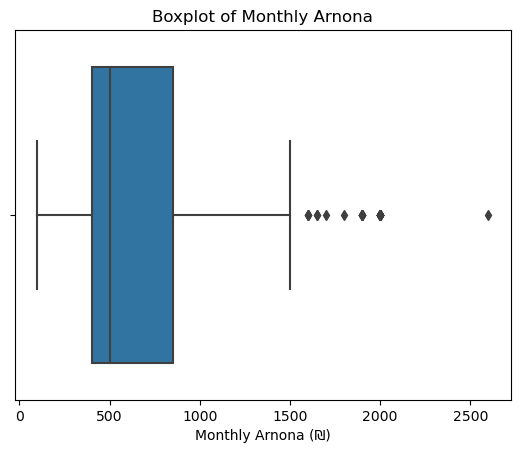

In [113]:
sns.boxplot(x=dataset['monthly_arnona'])
plt.title('Boxplot of Monthly Arnona')
plt.xlabel('Monthly Arnona (₪)')
plt.show()


## days_to_enter  column

In [114]:
dataset['days_to_enter'].unique()

array([ 0., nan, -1.])

We decided to convert to categories because we have no way of knowing the exact value.


## New column- entering_category 

In [115]:

# Function to map 'days_to_enter' values into categorical labels
def map_days_to_category(val):
    if pd.isna(val):
        return 'unknown'          
    elif val == 0:
        return 'immediate'        
    elif val == -1:
        return 'flexible'        
    else:
        return 'in_future'        


dataset['entering_category'] = dataset['days_to_enter'].apply(map_days_to_category)



In [116]:
# display categorys
dataset['entering_category'].unique()

array(['immediate', 'unknown', 'flexible'], dtype=object)

## num_of_payments column

In [117]:
dataset['num_of_payments'].unique()

array([12., 11.,  9., 10.,  0.,  1.,  6.,  3.,  2.,  4., nan])

The value zero is an outlier, so we decided to use the mode since we have no reliable way to fill in the missing values.


In [118]:
dataset['num_of_payments'] = dataset['num_of_payments'].replace(0, np.nan)
dataset['num_of_payments'] = dataset['num_of_payments'].fillna(dataset['num_of_payments'].mode()[0])


## neighborhood column

In [119]:
dataset['neighborhood'].unique()

array(['הצפון הישן החלק המרכזי', 'בית שטראוס', 'התקווה', 'הגוש הגדול',
       'נוה שרת', 'קרית שלום', 'יפו ד', 'נוה חן',
       'לב תל אביב החלק הדרומי', 'תל חיים', 'כרם התימנים', 'כפיר',
       'תל כביר', 'בצרון', 'שפירא', 'הצפון החדש החלק הצפוני',
       'תל ברוך צפון', 'נוה אליעזר', 'צפון יפו', 'נחלת יצחק',
       'מרכז יפו מזרחית לשדרות ירושלים', 'נוה שאנן', 'גבעת הרצל',
       'רמת החייל', 'רמת אביב החדשה', 'עזרא', 'יד אליהו', 'רביבים',
       'נוה ברבור', 'לב תל אביב החלק הצפוני', 'כוכב הצפון', 'גני צהלה',
       'נאות אפקה ב', 'אזורי חן', 'הדר יוסף', 'לבנה', 'לינקולן',
       'חוף הצוק', 'נאות אפקה א', 'פארק צמרת', 'הקריה', 'שיכוני חסכון',
       'המשתלה', 'צהלון', 'דקר', 'רמת הטייסים', 'רמת אביב', 'יפו ג',
       'רמת ישראל', 'אפקה', 'נמל תל אביב', 'נוה אביבים',
       'הצפון החדש החלק הדרומי', 'מע"ר צפוני', 'הצפון הישן החלק הצפוני',
       'הצפון הישן החלק הדרום מזרחי', 'רמת אביב ג', "עג'מי", 'פלורנטין',
       'שבזי', 'הצפון החדש סביבת ככר המדינה', 'שיכון בבלי', 'מונטיפיורי',

In [120]:
# Display missing values
dataset['neighborhood'].isna().sum()

0

## distance_from_center column

In [121]:
# Display missing values
dataset['distance_from_center'].isna().sum()

16

In [122]:
dataset['distance_from_center'].describe()


count       695.000000
mean       2750.651584
std        8306.077172
min           0.000000
25%           5.505500
50%        1631.000000
75%        3578.000000
max      186481.000000
Name: distance_from_center, dtype: float64

Outlier Handling for Distance from City Center
We identified outliers in the distance_from_center column using the IQR method. Values above the upper bound were considered abnormal. To correct them, we replaced these outliers with the median distance of similar listings based on the same street or, if unavailable, the same neighborhood. This method maintains geographic consistency and improves data quality. Listings without sufficient context were marked for manual review.

In [123]:
def fix_distance_outliers_by_street_and_neighborhood(dataset, column='distance_from_center'):
    import numpy as np
    import pandas as pd

    # Step 1: Calculate IQR (Interquartile Range) bounds
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR

    print(f"IQR upper bound: {upper_bound:.2f} meters")

    # Step 2: Calculate median distance per street and neighborhood using valid (non-outlier) data
    valid_data = dataset[dataset[column] <= upper_bound]
    street_medians = valid_data.groupby('street')[column].median()
    neighborhood_medians = valid_data.groupby('neighborhood')[column].median()

    # List to store rows that could not be fixed automatically
    manual_review_rows = []

    # Step 3: Fix each outlier row by replacing its value with a suitable median
    def fix_row(row):
        val = row[column]
        if val > upper_bound:
            street = row.get('street')
            neighborhood = row.get('neighborhood')

            # Use street median if available
            if pd.notna(street) and street in street_medians:
                return street_medians[street]
            # Otherwise, try neighborhood median
            elif pd.notna(neighborhood) and neighborhood in neighborhood_medians:
                return neighborhood_medians[neighborhood]
            else:
                manual_review_rows.append(row.name)
                return np.nan  # Leave as missing for manual handling

        return val  # Keep original value if not an outlier

    # Apply the fix_row function to each row in the dataset
    dataset[column] = dataset.apply(fix_row, axis=1)

    # Report rows that couldn't be fixed
    if manual_review_rows:
        print(f"\n⚠️ {len(manual_review_rows)} rows could not be automatically fixed – displaying for manual review:")
        display(dataset.loc[manual_review_rows, ['address', 'neighborhood', 'street', column]])
    else:
        print("✔️ All outliers were successfully corrected using street or neighborhood medians.")

    return dataset


In [124]:
#Activate the function
dataset = fix_distance_outliers_by_street_and_neighborhood(dataset)


IQR upper bound: 8936.74 meters

⚠️ 16 rows could not be automatically fixed – displaying for manual review:


,address,neighborhood,street,distance_from_center
209,אהרון בקר 9,תל ברוך צפון,אהרון בקר,NaN
368,קהילת ורשה 39,הדר יוסף,קהילת ורשה,NaN
381,קהילת ורשה 3,הדר יוסף,קהילת ורשה,NaN
391,יוניצמן 21,חוף הצוק,יוניצמן,NaN
392,מיכאל נאמן 18,חוף הצוק,מיכאל נאמן,NaN
393,יוניצ'מן 4,חוף הצוק,יוניצ'מן,NaN
394,יוניצמן,חוף הצוק,יוניצמן,NaN
395,הרצל רוזנבלום,חוף הצוק,הרצל רוזנבלום,NaN
396,יוניצמן,חוף הצוק,יוניצמן,NaN
397,יוניצמן,חוף הצוק,יוניצמן,NaN


We'll remove rows with missing values.


In [125]:
# Fill missing values in 'distance_from_center' with the global median
median_distance = dataset['distance_from_center'].median()
dataset['distance_from_center'].fillna(median_distance, inplace=True)

print(f"✅ Filled missing 'distance_from_center' values with global median: {median_distance:.2f}")

✅ Filled missing 'distance_from_center' values with global median: 1475.00


In [126]:
dataset['distance_from_center'].isna().sum()

0

## num_of_images column

In [127]:
dataset['num_of_images'].isna().sum()

1

There is one value that is missing, turn it to 0.

In [128]:
dataset['num_of_images'] = dataset['num_of_images'].fillna(0)

We will check the values in the column.

In [129]:
dataset['num_of_images'].describe()

count    711.000000
mean       6.661041
std        3.943494
min        0.000000
25%        4.000000
50%        6.000000
75%        9.000000
max       19.000000
Name: num_of_images, dtype: float64

It seems there are no outliers.

### prepare_data  

In [130]:
def prepare_data(dataset):

       
    
    
    
    
    
    if 'price' in dataset.columns:
        before = len(dataset)
        dataset.dropna(subset=['price'], inplace=True)
        print(f"❌ הוסרו {before - len(dataset)} שורות ללא price")

        # שלב 2 – שמירה על טווח מחירים סביר
        before = len(dataset)
        dataset = dataset[(dataset['price'] >= 1500) & (dataset['price'] <= 18500)]
        print(f"❌ הוסרו {before - len(dataset)} שורות עם מחיר מחוץ לטווח 1500–18500")
    else:
        print("⚠️ עמודת price לא קיימת – דילוג על שלבי סינון לפי מחיר")

    # שלב 3 – המרה של תווים חסרי מידע ל־NaN
    dataset.replace({'': np.nan, ' ': np.nan}, inplace=True)
    
    # שלב 4 – הסרת שורות בלי neighborhood ו־address גם יחד
    before = len(dataset)
    dataset = dataset[~(dataset["neighborhood"].isna() & dataset["address"].isna())].reset_index(drop=True)
    print(f"❌ הוסרו {before - len(dataset)} שורות שבהן גם neighborhood וגם address חסרים")

    # שלב 5 – הסרת שורות עם פחות מ־5 ערכים (שאינם 0 או NaN)
    before = len(dataset)
    dataset = dataset[dataset.apply(lambda row: (row != 0).sum() > 4, axis=1)]
    print(f"❌ הוסרו {before - len(dataset)} שורות עם 4 ערכים או פחות (לא 0 ולא NaN)")
    # סיכום כולל
   # print(f"\n📊 סך הכול נשארו {len(dataset)} שורות מתוך {start_rows} המקוריות.")

#################################################################################################################################

    # 🔹 שמירה על כמות שורות לפני עיבוד
    start_rows = len(dataset)
    
    # 🔹 שלב 1: סיווג לפי property_type
    def classify_property_type(val): 
        if not isinstance(val, str):
            return np.nan
        val_lower = val.lower()
        if 'סאבלט' in val_lower:
            return 'סאבלט'
        elif 'פרטי' in val_lower or 'קוטג' in val_lower or 'דו משפחתי' in val_lower:
            return 'פרטי'
        elif 'סטודיו' in val_lower or 'לופט' in val_lower:
            return 'סטודיו/לופט'
        elif 'גג' in val_lower or 'פנטהאוז' in val_lower:
            return 'גג/פנטהאוז'
        elif 'דופלקס' in val_lower:
            return 'דופלקס'
        elif 'דירת גן' in val_lower:
            return 'דירת גן'
        elif 'דירה' in val_lower or 'דירת' in val_lower:
            return 'דירה'
        else:
            return np.nan
    
    # 🔹 שלב 2: ניחוש לפי description
    def guess_type_from_description(desc):
        if pd.isna(desc):
            return np.nan
        desc = desc.lower()
        non_apartment_keywords = [
            r'משרד', r'משרדים', r'קליניקה', r'גלריה', r'סטודיו לאמן',
            r'חלל עבודה', r'תלת פאזי', r'מחסן', r'סדנה', r'בית מלאכה', r'מסחרי'
        ]
        for pattern in non_apartment_keywords:
            if re.search(rf'\b{pattern}\b', desc):
                return np.nan
        patterns = [
            (r'\bיחידת דיור\b', 'יחידת דיור'),
            (r'\bסאבלט\b', 'סאבלט'),
            (r'\b(פרטי|קוטג|דו משפחתי)\b', 'פרטי'),
            (r'\b(סטודיו|לופט)\b', 'סטודיו/לופט'),
            (r'\b(גג|פנטהאוז)\b', 'גג/פנטהאוז'),
            (r'\bדופלקס\b', 'דופלקס'),
            (r'\bדירת גן\b', 'דירת גן'),
            (r'\b(דירה|דירת)\b', 'דירה'),
            (r'\bחדר\b', 'דירה'),
            (r'\bבית\b', 'דירה'),
        ]
        for pattern, value in patterns:
            if re.search(pattern, desc):
                return value
        return np.nan
    
    # 🔹 החלה על הדאטה
    dataset['property_type_clean'] = dataset['property_type'].apply(classify_property_type)
    
    # 🔹 שלב השלמה לפי תיאור
    missing_mask = dataset['property_type_clean'].isna()
    dataset.loc[missing_mask, 'property_type_clean'] = dataset.loc[missing_mask, 'description'].apply(guess_type_from_description)
    
    # 🔹 מילוי "לא ידוע"
    dataset['property_type_clean'] = dataset['property_type_clean'].fillna('לא ידוע')
    
    # 🔹 סינון שורות עם "קורות חיים"
    before = len(dataset)
    dataset = dataset[~dataset['description'].str.contains('קורות חיים', case=False, na=False)]
    print(f"❌ הוסרו {before - len(dataset)} שורות עם התייחסות ל'קורות חיים'")
    
    # 🔹 הסרת שורות עם 'לא ידוע'
    before = len(dataset)
    dataset = dataset[dataset['property_type_clean'] != 'לא ידוע']
    print(f"❌ הוסרו {before - len(dataset)} שורות שבהן סוג הנכס לא זוהה (לא ידוע)")
    
    # 🔹 סיכום
    print(f"\n📊 סך הכול נשארו {len(dataset)} שורות מתוך {start_rows} המקוריות.")

####################################################################################################################################
    def split_address(address):
        if not isinstance(address, str):
            return pd.Series([None, None])
        match = re.search(r'(\D+)\s*(\d+)?', address)
        if match:
            street = match.group(1).strip()
            number = match.group(2) if match.group(2) else None
            return pd.Series([street, number])
        return pd.Series([None, None])

    dataset[['street', 'house_number']] = dataset['address'].apply(split_address)
    dataset.drop('house_number', axis=1, inplace=True)

    conditions = (dataset['floor'].isna()) & (dataset['property_type'].isin(['פרטי']))
    dataset.loc[conditions, 'floor'] = 0
    dataset['street'] = dataset['street'].fillna("Unknown")
######################################################################################################################
    def extract_floor_clean(val):
        if pd.isna(val):
            return np.nan
        val = str(val).strip()
        if val == 'קרקע מתוך קרקע':
            return 0
        if 'קרקע' in val:
            return 0
        if 'מרתף' in val:
            return -1
        match = re.findall(r'\d+', val)
        if match:
            try:
                num = int(match[0])
                if 0 <= num <= 100:
                    return num
            except:
                return np.nan
        return np.nan

    dataset['floor_clean'] = dataset.apply(lambda row: extract_floor_clean(row['floor']), axis=1)
    dataset['floor_clean'] = pd.to_numeric(dataset['floor_clean'], errors='coerce')
    condition = (dataset['total_floors'] == 0) & (dataset['floor_clean'].isin([0, 1]))
    dataset.loc[condition, 'total_floors'] = 1

    def extract_floor_strict(val, total_floors):
        if pd.isnull(val):
            return np.nan
        val = str(val).strip()
        if val == '0' or 'קרקע' in val:
            return 1
        match = re.search(r'\d+', val)
        if not match:
            return np.nan
        num_str = match.group()
        try:
            num = int(num_str)
        except:
            return np.nan
        if 0 < num <= 100:
            return num
        if not pd.isnull(total_floors):
            tf_str = str(int(total_floors))
            if num_str.endswith(tf_str):
                floor_part = num_str[:-len(tf_str)]
                if floor_part.isdigit():
                    floor_val = int(floor_part)
                    if 0 < floor_val <= 100:
                        return floor_val
        return np.nan


    dataset['floor_clean'] = dataset.apply(
        lambda row: extract_floor_strict(row['floor'], row['total_floors']),
        axis=1
    )

# פונקציה לחילוץ מספר קומה מהתיאור
    def extract_floor_from_description(desc):
        if pd.isna(desc):
            return np.nan
        desc = desc.lower()

        # קומה מספרית רגילה: "קומה 3", "בקומה 10", "קומה: 5"
        match = re.search(r'קומ[ה|ת] (?:מס\' )?(\d{1,2})', desc)
        if match:
            return int(match.group(1))

        # קומה מעל משהו – לדוגמה "מעל קומה 20"
        match = re.search(r'מעל.*?(\d{1,2})', desc)
        if match:
            return int(match.group(1)) + 1

        # קומת קרקע
        if 'קומת קרקע' in desc or 'קרקע' in desc:
            return 0

        return np.nan

    # שמירת עותק של העמודה לפני השינויים
    original_floor = dataset['floor_clean'].copy()

    # סינון שורות עם ערך חסר בקומה
    missing_floor_mask = dataset['floor_clean'].isna()
    dataset.loc[missing_floor_mask, 'floor_clean'] = dataset.loc[missing_floor_mask, 'description'].apply(extract_floor_from_description)

    
    dataset.dropna(subset=['floor_clean'], inplace=True) #1


    def fix_merged_floor(row):
        floor = row['floor_clean']
        total = row['total_floors']
        if pd.notna(floor) and pd.notna(total):
            if floor > total:
                digits = [int(d) for d in str(int(floor)) if d.isdigit()]
                if int(total) in digits:
                    digits.remove(int(total))
                    if digits:
                        new_floor = digits[0]
                        if new_floor <= total:
                            return new_floor
        return floor

    dataset['floor_clean'] = dataset.apply(fix_merged_floor, axis=1)

###############################################################################################################
    mask = (
        (dataset['floor_clean'] > dataset['total_floors']) &
        (dataset['floor_clean'].notna()) &
        (dataset['total_floors'].notna())
    )
    dataset.loc[mask, 'total_floors'] = np.nan

    def extract_total_floors_from_floor(val):
        if pd.isna(val):
            return np.nan
        val = str(val).strip()
        if val == 'קרקע מתוך קרקע':
            return 1
        if 'קרקע מתוך' in val:
            match = re.search(r'קרקע מתוך (\d+)', val)
            if match:
                return int(match.group(1))
            else:
                return np.nan
        match = re.findall(r'\d+', val)
        if len(match) >= 2:
            return int(match[-1])
        return np.nan

    mask_missing = dataset['total_floors'].isna()
    dataset.loc[mask_missing, 'total_floors'] = dataset.loc[mask_missing, 'floor'].apply(extract_total_floors_from_floor)
    dataset['total_floors'] = dataset['total_floors'].astype(float)

    # ✅ שלב 1: יצירת קטגוריות זמניות של מיסי בניין
    dataset['_building_tax_bin'] = pd.qcut(dataset['building_tax'], q=4, duplicates='drop')
    
    # ✅ שלב 2: חישוב חציון total_floors לפי elevator + has_parking + tax_bin
    group_median = dataset.groupby(['elevator', 'has_parking', '_building_tax_bin'])['total_floors'].median()
    
    # ✅ שלב 3: פונקציית מילוי חכמה שמתחשבת גם בקומה בפועל
    def smart_fill(row):
        if pd.notna(row['total_floors']):
            return row['total_floors']
    
        try:
            group_value = group_median.loc[row['elevator'], row['has_parking'], row['_building_tax_bin']]
        except:
            group_value = dataset['total_floors'].median()
    
        if pd.notna(row.get('floor_clean')):
            return max(group_value, row['floor_clean'])
        else:
            return group_value
    
    # ✅ שלב 4: הפעלת הפונקציה על כל השורות
    dataset['total_floors'] = dataset.apply(smart_fill, axis=1)
    
    # ✅ שלב 5: הסרת העמודה הזמנית
    dataset.drop('_building_tax_bin', axis=1, inplace=True)

  
    
########################################################################################################################################
    # עיבוד garden_area
    def extract_garden_area(desc):
        if pd.isna(desc):
            return np.nan
        desc = desc.replace(',', '')
        match = re.search(r'גינה[^0-9]{0,10}(\d{1,4}) ?מ"ר', desc)
        if match:
            try:
                area = int(match.group(1))
                if 1 <= area <= 300:
                    return area
            except:
                return np.nan
        return np.nan

    dataset['garden_area_filled'] = dataset['garden_area']
    missing_mask = dataset['garden_area'].isna()
    dataset.loc[missing_mask, 'garden_area_filled'] = dataset.loc[missing_mask, 'description'].apply(extract_garden_area)

    mask = (
        dataset['garden_area_filled'].isna() &
        (dataset['floor_clean'] > 3) &
        (dataset['has_balcony'] == 0) &
        (dataset['property_type_clean'].isin(['דירה', 'דופלקס']))
    )
    dataset.loc[mask, 'garden_area'] = 0
    dataset['garden_area_filled'] = dataset['garden_area_filled'].fillna(0)
########################################################################################################################
    def categorize_garden_area(x):
        if pd.isna(x):
            return 'לא ידוע'
        elif x == 0:
            return 'אין גינה'
        elif x <= 20:
            return 'קטנה'
        elif x <= 50:
            return 'בינונית'
        else:
            return 'גדולה'

    dataset['garden_size_category'] = dataset['garden_area'].apply(categorize_garden_area)
#########################################################################################################################
    # עיבוד room_num
 # ✅ שלב מקדים: החלפת אפסים ב-NaN
    dataset['room_num'] = dataset['room_num'].replace(0, np.nan)
    
    # ✅ פונקציית חילוץ מחדרים
    def extract_room_num_from_description(description):
        if pd.isnull(description):
            return np.nan
    
        description = str(description).strip()
    
        hebrew_numbers = {
            'חדר אחד': 1,
            'חדר וחצי': 1.5,
            'חדרים וחצי': 1.5,
            'שניים': 2,
            'שני': 2,
            'שתי': 2,
            'שלושה': 3,
            'שלוש': 3,
            'ארבעה': 4,
            'ארבע': 4,
            'חמישה': 5,
            'חמש': 5,
            'שישה': 6,
            'שש': 6,
            'שבעה': 7,
            'שבע': 7,
            'שמונה': 8,
            'תשעה': 9,
            'תשע': 9,
            'עשרה': 10
        }

        # 1. תבניות כמו "3 חדרים", "2.5 חדרים"
        match = re.search(r'(?:דירת|כוללת)?\s*(\d(?:[.,]\d)?)\s*חדרים?', description)
        if match:
            try:
                return float(match.group(1).replace(',', '.'))
            except:
                return np.nan
    
        # 2. מספר לפני "חדר"
        match = re.search(r'(\d(?:[.,]\d)?)\s*חדר', description)
        if match:
            try:
                return float(match.group(1).replace(',', '.'))
            except:
                return np.nan
    
        # 3. מיפוי של מילים
        for word_form, number in hebrew_numbers.items():
            if re.search(rf'{word_form}\s*חדר', description):
                return number
    
        # 4. fallback – רק "חדר"
        if re.search(r'\bחדר\b', description):
            return 1
    
        return np.nan
    
    # ✅ יצירת עמודה חדשה
    dataset['room_num_from_desc'] = dataset['description'].apply(extract_room_num_from_description)
    
    # ✅ מילוי לפי תיאור
    condition = (
        dataset['room_num'].isna() &
        dataset['room_num_from_desc'].notna() &
        (dataset['room_num_from_desc'] != 0)
    )
    dataset.loc[condition, 'room_num'] = dataset.loc[condition, 'room_num_from_desc']
    
    # ✅ אינדקציה על שורות שיוסרו
    before_drop = len(dataset)
    dataset.dropna(subset=['room_num'], inplace=True)
    after_drop = len(dataset)
    print(f"❌ הוסרו {before_drop - after_drop} שורות ללא ערך ב-room_num לאחר ניסיון המילוי מתיאור.")

################################################################################################################
# עיבוד area
    Q1 = dataset['area'].quantile(0.25)
    Q3 = dataset['area'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask_outliers = (dataset['area'] < 15) | (dataset['area'] > upper_bound)
    dataset.loc[mask_outliers, 'area'] = np.nan

    median_area_by_room = dataset.groupby('room_num')['area'].median()
    dataset['area'] = dataset.apply(
        lambda row: median_area_by_room[row['room_num']] if pd.isna(row['area']) else row['area'],
        axis=1
    )
#################################################################################################################
    # עיבוד building_tax
    Q1 = dataset['building_tax'].quantile(0.25)
    Q3 = dataset['building_tax'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = 0

    high_outliers_mask = dataset['building_tax'] > 1500
    dataset.loc[high_outliers_mask, 'building_tax'] = np.nan

    low_outliers_mask = (dataset['building_tax'] < 50) & (dataset['building_tax'] != 0)
    dataset.loc[low_outliers_mask, 'building_tax'] = np.nan

    mask = dataset['property_type_clean'] == 'פרטי'
    dataset.loc[mask, 'building_tax'] = 0

    def categorize_building_tax(value):
        if pd.isna(value):
            return "לא יודע"
        elif 0 <= value < 500:
            return "זול"
        elif 500 <= value < 1000:
            return "ממוצע"
        elif 1000 <= value <= 1500:
            return "גבוה"
        else:
            return "לא ידוע"

    dataset["building_tax_category"] = dataset["building_tax"].apply(categorize_building_tax)
    dataset["building_tax_category"] = dataset["building_tax_category"].astype("category")

    def extract_building_tax(desc):
        if pd.isna(desc):
            return np.nan
        desc = desc.replace(',', '')
        patterns = [
            r'מיס[י|י] [ה]?בנ[יי]ן[^0-9]{0,10}(\\d{2,5})',
            r'ועד[^0-9]{0,10}(\\d{2,5})',
            r'עד בנ[יי]ן[^0-9]{0,10}(\\d{2,5})',
        ]
        for pattern in patterns:
            match = re.search(pattern, desc)
            if match:
                try:
                    value = int(match.group(1))
                    if 0 < value < 3000:
                        return value
                except:
                    return np.nan
        return np.nan

    missing_mask = dataset['building_tax'].isna()
    dataset.loc[missing_mask, 'building_tax'] = dataset.loc[missing_mask, 'description'].apply(extract_building_tax)

    dataset['total_floors_round'] = dataset['total_floors'].round()
    group1 = dataset.groupby(['has_parking', 'total_floors_round', 'has_safe_room'])['building_tax'].median()
    group2 = dataset.groupby(['property_type_clean', 'neighborhood'])['building_tax'].median()

    def fill_building_tax(row):
        if pd.notna(row['building_tax']):
            return row['building_tax']
        try:
            val = group1.loc[row['has_parking'], row['total_floors_round'], row['has_safe_room']]
            if pd.notna(val):
                return val
        except:
            pass
        try:
            val = group2.loc[row['property_type_clean'], row['neighborhood']]
            if pd.notna(val):
                return val
        except:
            pass
        return dataset['building_tax'].median()

    dataset['building_tax'] = dataset.apply(fill_building_tax, axis=1)
    dataset.drop('total_floors_round', axis=1, inplace=True)
################################################################################################################################
    # עיבוד monthly_arnona
    dataset.loc[dataset['monthly_arnona'] == 0, 'monthly_arnona'] = np.nan
    dataset.loc[dataset['monthly_arnona'] < 100, 'monthly_arnona'] = np.nan
    dataset.loc[dataset['monthly_arnona'] > 5000, 'monthly_arnona'] = np.nan

    def fill_missing_arnona(row):
        if pd.notna(row['monthly_arnona']):
            return row['monthly_arnona']

        area_min = row['area'] - 5
        area_max = row['area'] + 5
        rooms_min = row['room_num'] - 1
        rooms_max = row['room_num'] + 1

        similar = dataset[
            (dataset['neighborhood'] == row['neighborhood']) &
            (dataset['area'] >= area_min) & (dataset['area'] <= area_max) &
            (dataset['room_num'] >= rooms_min) & (dataset['room_num'] <= rooms_max) &
            (dataset['monthly_arnona'].notna())
        ]

        if not similar.empty:
            return similar['monthly_arnona'].mean()
        else:
            return np.nan

    dataset['monthly_arnona'] = dataset.apply(fill_missing_arnona, axis=1)

    def fill_arnona_by_address_or_neighborhood(row):
        if pd.notna(row['monthly_arnona']):
            return row['monthly_arnona']

        if pd.notna(row['street']):
            street_mask = (dataset['street'] == row['street']) & dataset['monthly_arnona'].notna()
            if street_mask.sum() >= 3:
                return dataset.loc[street_mask, 'monthly_arnona'].median()

        if pd.notna(row['neighborhood']):
            neigh_mask = (dataset['neighborhood'] == row['neighborhood']) & dataset['monthly_arnona'].notna()
            if neigh_mask.sum() >= 3:
                return dataset.loc[neigh_mask, 'monthly_arnona'].median()

        return np.nan

    dataset['monthly_arnona'] = dataset.apply(fill_arnona_by_address_or_neighborhood, axis=1)

    def fill_arnona_by_distance_similarity(row, median_distance_by_neigh, median_arnona_by_neigh, global_median):
        if pd.notna(row['monthly_arnona']):
            return row['monthly_arnona']

        if pd.isna(row['distance_from_center']):
            return global_median

        diffs = (median_distance_by_neigh - row['distance_from_center']).abs()
        closest_neigh = diffs.idxmin()
        value = median_arnona_by_neigh.get(closest_neigh, np.nan)
        if pd.isna(value):
            return global_median
        return value

    median_distance_by_neigh = dataset.groupby('neighborhood')['distance_from_center'].median()
    median_arnona_by_neigh = dataset.groupby('neighborhood')['monthly_arnona'].median()
    global_median_arnona = dataset['monthly_arnona'].median()

    dataset['monthly_arnona'] = dataset.apply(
        lambda row: fill_arnona_by_distance_similarity(
            row,
            median_distance_by_neigh,
            median_arnona_by_neigh,
            global_median_arnona
        ),
        axis=1
    )
#########################################################################################################################
# עיבוד entering_category
    def map_days_to_category(val):
        if pd.isna(val):
            return 'unknown'
        elif val == 0:
            return 'immediate'
        elif val == -1:
            return 'flexible'
        else:
            return 'in_future'

    dataset['entering_category'] = dataset['days_to_enter'].apply(map_days_to_category)
##########################################################################################################################
    # עיבוד num_of_payments
    dataset['num_of_payments'] = dataset['num_of_payments'].replace(0, np.nan)
    dataset['num_of_payments'] = dataset['num_of_payments'].fillna(dataset['num_of_payments'].mode()[0])
    
    # num_of_images
    dataset['num_of_images'] = dataset['num_of_images'].fillna(0)

    #עיבוד distance_from_center
    def fill_missing_distances_via_api(dataset, api_key, center_address="כיכר דיזנגוף, תל אביב"):
        def format_address(addr):
            if not isinstance(addr, str) or not addr.strip():
                return None
            if "תל אביב" not in addr:
                addr += ", תל אביב"
            return addr

#         def get_distance(origin, destination, api_key):
#             url = f"https://routes.googleapis.com/directions/v2:computeRoutes"
#             headers = {
#                 'Content-Type': 'application/json',
#                 'X-Goog-Api-Key': api_key,
#                 'X-Goog-FieldMask': 'routes.distanceMeters'
#             }
#             body = {
#                 "origin": {"address": origin},
#                 "destination": {"address": destination},
#                 "travelMode": "DRIVE",
#                 "routingPreference": "TRAFFIC_AWARE"
#             }

#             response = requests.post(url, headers=headers, json=body)
#             if response.status_code == 200:
#                 data = response.json()
#                 if 'routes' in data and data['routes']:
#                     return float(data['routes'][0]['distanceMeters'])
#             return None

#         missing = dataset[dataset['distance_from_center'].isna()].copy()

#         for i, row in missing.iterrows():
#             address = format_address(row.get('address')) or format_address(row.get('street'))
#             if not address:
#                 continue

#             distance = get_distance(address, center_address, api_key)
#             time.sleep(0.2)

#             if distance is not None:
#                 dataset.at[i, 'distance_from_center'] = distance

#         return dataset
#     api_key =getpass.getpass()
#     dataset = fill_missing_distances_via_api(dataset, api_key=api_key)    
#     dataset.dropna(subset=['distance_from_center'], inplace=True)
      
    # Fill missing values in 'distance_from_center' with the global median
    median_distance = dataset['distance_from_center'].median()
    dataset['distance_from_center'].fillna(median_distance, inplace=True)

    
    
    
    
    return dataset  
    
    
    
    
    

We will check if the function works.

In [131]:
my_data_test=prepare_data(my_data_test)


❌ הוסרו 2 שורות ללא price
❌ הוסרו 53 שורות עם מחיר מחוץ לטווח 1500–18500
❌ הוסרו 2 שורות שבהן גם neighborhood וגם address חסרים
❌ הוסרו 0 שורות עם 4 ערכים או פחות (לא 0 ולא NaN)
❌ הוסרו 1 שורות עם התייחסות ל'קורות חיים'
❌ הוסרו 11 שורות שבהן סוג הנכס לא זוהה (לא ידוע)

📊 סך הכול נשארו 719 שורות מתוך 731 המקוריות.


C:\Users\ngr25\AppData\Local\Temp\ipykernel_38764\488166565.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.replace({'': np.nan, ' ': np.nan}, inplace=True)


❌ הוסרו 7 שורות ללא ערך ב-room_num לאחר ניסיון המילוי מתיאור.


In [132]:
#Comparison between the data we worked on and the data we entered to prepare_data

#Original data
print(len(dataset))
#Data that we checked
print(len(my_data_test))

711
711


### Adding features

In [133]:
luxury_types = ['גג/פנטהאוז', 'דופלקס']
my_data_test['is_luxury_type'] = my_data_test['property_type'].isin(luxury_types).astype(int)

# Section B - Building Models

In [134]:
my_data_test.columns

Index(['property_type', 'neighborhood', 'address', 'room_num', 'floor', 'area',
       'garden_area', 'days_to_enter', 'num_of_payments', 'monthly_arnona',
       'building_tax', 'total_floors', 'description', 'has_parking',
       'has_storage', 'elevator', 'ac', 'handicap', 'has_bars',
       'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
       'num_of_images', 'distance_from_center', 'price', 'property_type_clean',
       'street', 'floor_clean', 'garden_area_filled', 'garden_size_category',
       'room_num_from_desc', 'building_tax_category', 'entering_category',
       'is_luxury_type'],
      dtype='object')

In [135]:
my_data_test.isna().sum()

property_type              0
neighborhood               0
address                   22
room_num                   0
floor                      2
area                       0
garden_area              121
days_to_enter            162
num_of_payments            0
monthly_arnona             0
building_tax               0
total_floors               0
description                3
has_parking                0
has_storage                0
elevator                   0
ac                         0
handicap                   0
has_bars                   0
has_safe_room              0
has_balcony                0
is_furnished               0
is_renovated               0
num_of_images              0
distance_from_center       0
price                      0
property_type_clean        0
street                     0
floor_clean                0
garden_area_filled         0
garden_size_category       0
room_num_from_desc       148
building_tax_category      0
entering_category          0
is_luxury_type

#### Correlation Matrix

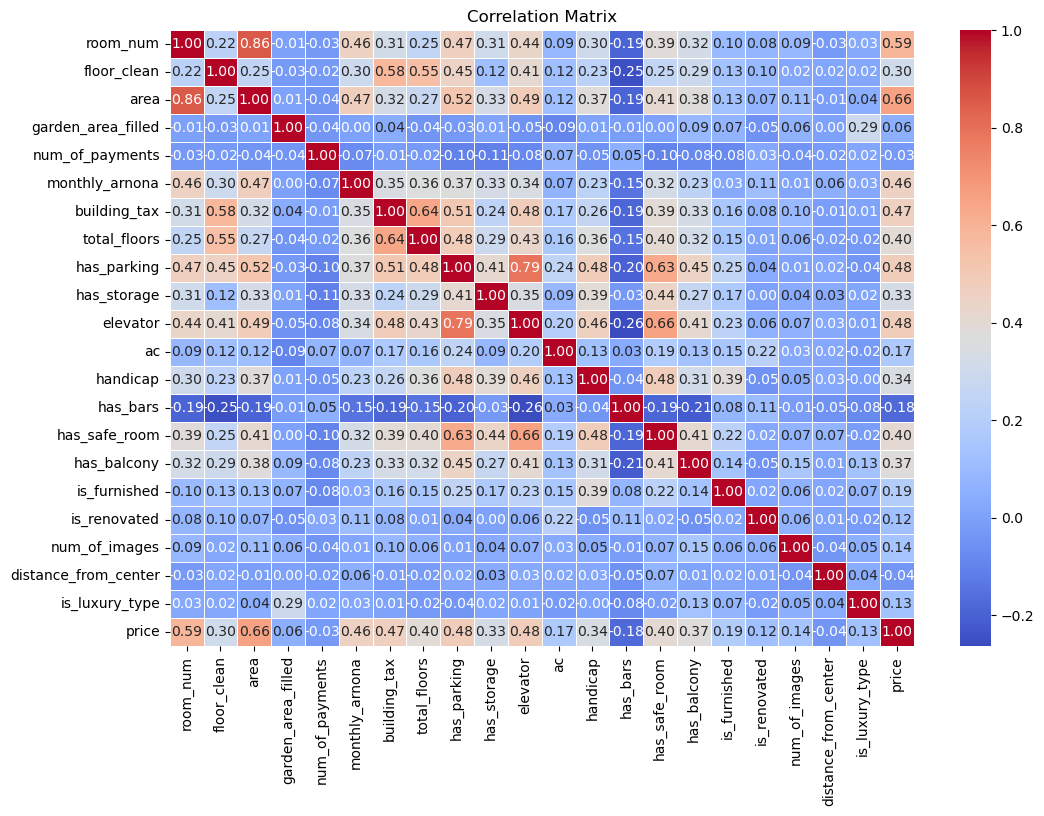

In [136]:

numeric_cols =[ 'room_num', 'floor_clean', 'area',
       'garden_area_filled', 'num_of_payments', 'monthly_arnona',
       'building_tax', 'total_floors', 'has_parking',
       'has_storage', 'elevator', 'ac', 'handicap', 'has_bars',
       'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
       'num_of_images', 'distance_from_center','is_luxury_type','price']
corr_matrix = my_data_test[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [137]:
features=['property_type_clean', 'neighborhood', 'street', 'room_num', 'floor_clean', 'area',
       'garden_area_filled', 'garden_size_category','entering_category', 'num_of_payments', 'monthly_arnona',
       'building_tax', 'total_floors', 'has_parking',
       'has_storage', 'elevator', 'ac', 'handicap', 'has_bars',
       'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
       'num_of_images', 'distance_from_center', 'price','building_tax_category' ]
my_data_test=my_data_test[features]

You checked the correlation to the price

In [138]:
# בדיקת קורלציה רק לעמודות מספריות מול price
numeric_cols = dataset.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

correlations = dataset[numeric_cols].corr()['price'].sort_values(ascending=False)

# הצגת התוצאה
print("🔍 Correlation with Price:")
print(correlations)


🔍 Correlation with Price:
price                   1.000000
area                    0.656621
room_num                0.585797
elevator                0.481044
has_parking             0.480781
building_tax            0.472744
monthly_arnona          0.458554
room_num_from_desc      0.446797
has_safe_room           0.404407
total_floors            0.384928
has_balcony             0.374824
handicap                0.339285
has_storage             0.332508
floor_clean             0.245125
is_furnished            0.191476
ac                      0.174790
num_of_images           0.144614
is_renovated            0.122421
garden_area             0.075108
garden_area_filled      0.057081
num_of_payments        -0.025190
distance_from_center   -0.048211
days_to_enter          -0.157333
has_bars               -0.175504
Name: price, dtype: float64


### Elastic Net

In [139]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ========== Step 1: Feature Engineering ==========
# Create a copy of the dataset with selected features
df_selected = my_data_test[features].copy()

# ========== Step 2: Define X and y ==========
X = df_selected.drop("price", axis=1)  # Features
y = df_selected["price"]              # Target variable

# ========== Step 3: Train/Test Split ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Step 4: Define Transformers ==========
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# Define transformer for categorical features (imputation + encoding)
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Define transformer for numeric features (imputation + scaling)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

# Combine transformers into a column transformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# ========== Step 5: Create Pipeline with ElasticNet ==========
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.3))  # Sample hyperparameters
])

# ========== Step 6: Cross Validation ==========
# Perform 10-fold CV using negative MAE as the scoring metric
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")
mean_cv_mae = -np.mean(cv_scores)  # Convert negative to positive MAE

# ========== Step 7: Train the Model ==========
pipeline.fit(X_train, y_train)

# ========== Step 8: Evaluate Model Performance ==========
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"📊 MAE: {mae:.2f} ₪")
print(f"📉 RMSE: {rmse:.2f} ₪")
print(f"🔢 R²: {r2:.4f}")
print(f"📚 10-Fold CV MAE: {mean_cv_mae:.2f} ₪")

# ========== Step 9: Feature Importance (ElasticNet Coefficients) ==========
# Retrieve transformed feature names
cat_features = pipeline.named_steps["preprocessor"].named_transformers_["cat"]["encoder"].get_feature_names_out(categorical_cols)
num_features = numeric_cols
all_features = np.concatenate([num_features, cat_features])

# Extract model coefficients
coefficients = pipeline.named_steps["regressor"].coef_

# Create a Series mapping features to their coefficients
feature_importance = pd.Series(coefficients, index=all_features)

# Sort by absolute importance and show top 5
top5 = feature_importance.reindex(feature_importance.abs().sort_values(ascending=False).index).head(5)
print("\n🔥 Top 5 Influential Features:")
print(top5)


📊 MAE: 1866.73 ₪
📉 RMSE: 2512.63 ₪
🔢 R²: 0.5147
📚 10-Fold CV MAE: 1755.99 ₪

🔥 Top 5 Influential Features:
area                        1816.864712
room_num                    1418.332775
building_tax                 993.979848
monthly_arnona               940.516130
neighborhood_כרם התימנים     684.233074
dtype: float64


The five important features are:

area                        
room_num                  
building_tax                 
monthly_arnona             
neighborhood כרם התמנים       

We chose these features because we tested them and they had the most positive impact on the model's predictions.

In [140]:
features=['property_type_clean', 'neighborhood', 'street', 'room_num', 'floor_clean', 'area',
       'garden_area_filled', 'garden_size_category','entering_category', 'num_of_payments', 'monthly_arnona',
       'building_tax', 'total_floors', 'has_parking',
       'has_storage', 'elevator', 'ac', 'handicap', 'has_bars',
       'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
       'num_of_images', 'distance_from_center', 'price','building_tax_category' ]

### RandomForestRegressor

In [141]:
# ---------- Define selected features ----------
features = ['property_type_clean', 'neighborhood', 'street', 'room_num', 'floor_clean', 'area',
            'garden_area_filled', 'garden_size_category', 'entering_category', 'num_of_payments',
            'monthly_arnona', 'building_tax', 'total_floors', 'has_parking', 'has_storage', 'elevator',
            'ac', 'handicap', 'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
            'num_of_images', 'distance_from_center', 'price', 'building_tax_category']

# ---------- Select data ----------
df = my_data_test[features].copy()

# ---------- Split into X (features) and y (target) ----------
X = df.drop("price", axis=1)
y = df["price"]

# ---------- Identify column types ----------
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# ---------- Define transformations for categorical columns ----------
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing with most frequent
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))  # One-hot encode categories
])

# ---------- Define transformations for numeric columns ----------
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # Fill missing with median
    ("scaler", MinMaxScaler())  # Normalize between 0 and 1
])

# ---------- Combine all transformations ----------
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# ---------- Create pipeline with preprocessing and Random Forest model ----------
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# ---------- Split data into train/test sets ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- Train the model ----------
pipeline.fit(X_train, y_train)

# ---------- Make predictions ----------
predictions = pipeline.predict(X_test)

# ---------- Evaluate model performance ----------
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"📊 MAE: {mae:.2f} ₪")
print(f"📉 RMSE: {rmse:.2f} ₪")
print(f"📈 R²: {r2:.4f}")

# ---------- Feature importance ----------
# Get transformed feature names
feature_names = numeric_cols + list(
    pipeline.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['encoder']
    .get_feature_names_out(categorical_cols)
)

# Get importance values from the trained model
importances = pipeline.named_steps["regressor"].feature_importances_

# Create DataFrame of feature importances
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Display top 5 most important features
top5 = importance_df.head(5)
print("\n🌟 Top 5 Most Important Features:")
print(top5.to_string(index=False))


📊 MAE: 1540.95 ₪
📉 RMSE: 2181.76 ₪
📈 R²: 0.6341

🌟 Top 5 Most Important Features:
             feature  importance
                area    0.446630
        building_tax    0.108267
      monthly_arnona    0.055748
            room_num    0.047180
distance_from_center    0.035827


### Comparison test between the models

In [142]:

# ---------- שלב 1: הגדרת features ----------
features = ['property_type_clean', 'neighborhood', 'street', 'room_num', 'floor_clean', 'area',
            'garden_area_filled', 'garden_size_category','entering_category', 'num_of_payments',
            'monthly_arnona', 'building_tax', 'total_floors', 'has_parking', 'has_storage', 'elevator',
            'ac', 'handicap', 'has_bars', 'has_safe_room', 'has_balcony', 'is_furnished', 'is_renovated',
            'num_of_images', 'distance_from_center', 'price', 'building_tax_category']

df = my_data_test[features].copy()
X = df.drop("price", axis=1)
y = df["price"]

categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "bool"]).columns.tolist()

# ---------- שלב 2: טרנספורמציה ----------
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse=False))
])

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# ---------- שלב 3: Train/Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------- שלב 4: הגדרת שני המודלים ----------
# ElasticNet
elastic_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", ElasticNet(alpha=0.1, l1_ratio=0.3, random_state=42))
])

# Random Forest
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# ---------- שלב 5: אימון וחיזוי ----------
elastic_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

elastic_preds = elastic_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# ---------- שלב 6: הערכת ביצועים ----------
def print_metrics(name, y_test, preds):
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    print(f"\n📊 {name} Model:")
    print(f"MAE  : {mae:.2f} ₪")
    print(f"RMSE : {rmse:.2f} ₪")
    print(f"R²   : {r2:.4f}")

print_metrics("ElasticNet", y_test, elastic_preds)
print_metrics("Random Forest", y_test, rf_preds)

# ---------- שלב 7: שמות כל הפיצ'רים לאחר טרנספורמציה ----------
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
ohe_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(ohe_features)

# ---------- שלב 8: 5 הפיצ'רים החשובים ביותר ברנדום פורסט ----------
rf_importances = rf_model.named_steps["regressor"].feature_importances_
rf_feature_importance = pd.Series(rf_importances, index=all_features)
top5_rf = rf_feature_importance.sort_values(ascending=False).head(5)

print("\n🌲 Top 5 Most Important Features in Random Forest:")
print(top5_rf)

# ---------- שלב 9: 5 הפיצ'רים החשובים ביותר באלסטיק נט ----------
elastic_coeffs = elastic_model.named_steps["regressor"].coef_
elastic_feature_importance = pd.Series(np.abs(elastic_coeffs), index=all_features)
top5_elastic = elastic_feature_importance.sort_values(ascending=False).head(5)

print("\n📉 Top 5 Most Influential Features in ElasticNet (by absolute coefficient):")
print(top5_elastic)



📊 ElasticNet Model:
MAE  : 1866.73 ₪
RMSE : 2512.63 ₪
R²   : 0.5147

📊 Random Forest Model:
MAE  : 1540.95 ₪
RMSE : 2181.76 ₪
R²   : 0.6341

🌲 Top 5 Most Important Features in Random Forest:
area                    0.446630
building_tax            0.108267
monthly_arnona          0.055748
room_num                0.047180
distance_from_center    0.035827
dtype: float64

📉 Top 5 Most Influential Features in ElasticNet (by absolute coefficient):
area                        1816.864712
room_num                    1418.332775
building_tax                 993.979848
monthly_arnona               940.516130
neighborhood_כרם התימנים     684.233074
dtype: float64


Question: Is there a match between the most important characteristics of each of the models

Answer:
It is possible to see that the important pieces in both models are already the same
(area,building_tax,monthly_arnona,room_num) in feature 5 they are different(Random Forest=distance_from_center,ElasticNet=neighborhood)




Question:Explain the differences or similarities between the models and the possible reasons for these differences.

Answer:The Random Forest model provided higher R² values (for example,0.6234 compared to 0.5145), indicating that it learned the data better.The main reason for this is that the price likely depends on a complex combination of factors (for example: an apartment on the 5th floor with an elevator is worth much more than an apartment on the 5th floor without an elevator), and such relationships are not recognized by ElasticNet.